In [ ]:
# ==============================
# Temel kütüphaneler
# ==============================
import os
import math
import warnings
import numpy as np
import pandas as pd

# ==============================
# Görselleştirme
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Ön işleme ve ölçeklendirme
# ==============================
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# ==============================
# Modelleme - Regresyon
# ==============================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# ==============================
# Modelleme - Sınıflandırma
# ==============================
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor  # veya XGBRegressor
# ==============================
# Model seçimi ve değerlendirme
# ==============================
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    explained_variance_score,
    max_error,
    classification_report,
    confusion_matrix
)

# ==============================
# Kümeleme ve boyut indirgeme
# ==============================
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [2]:
print(os.getcwd())

c:\Users\nesri\repos\bitirme projesi\GlobalDentalStats\notebooks


In [3]:
df = pd.read_excel("../data/processed_data/merged_df_25.08last.xlsx")

In [4]:
df.head(5)

,Location,Period,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
0,Angola,2019,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482,166,316
1,Burundi,2019,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92,30,62
2,Benin,2019,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74,42,32
3,Burkina Faso,2019,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179,55,124
4,Botswana,2019,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60,8,52


| Sütun Adı                      | Açıklama                                                                   |
|--------------------------------|----------------------------------------------------------------------------|
| Location                       | Ülke adı (örneğin: Angola)                                                 |
| Period                         | Veri yılı (örneğin: 2019)                                                  |
| TotalExpenditure               | Diş Sağlığı Hizmetleri – Toplam Harcama (milyon USD)                              |
| PerCapitaExpenditure           | Kişi Başına Diş Sağlığı Harcaması (USD)                                    |
| EdentulismRate                 | 20 Yaş Üstü Bireylerde Dişsizlik Yaygınlığı (%)                            |
| PeriodontalRate                | 15 Yaş Üstü Bireylerde Şiddetli Periodontal Hastalık Yaygınlığı (%)        |
| UntreatedCariesRate            | 5 Yaş Üstü Bireylerde Kalıcı Dişlerde Tedavi Edilmemiş Çürük Yaygınlığı (%)|
| UntreatedDeciduousCaries1_9Rate| 1–9 Yaş Arası Çocuklarda Süt Dişi Çürüğü (Tedavi Edilmemiş) Yaygınlığı     |
| ProductivityLossRate           | 5 Ağız Hastalığı Nedeniyle Toplam Üretkenlik Kaybı (USD)                   |
| both_cancer                    | Dudak ve Ağız Boşluğu Kanseri: Toplam nüfus icin yeni vaka sayisi          |
| female_cancer                  | Dudak ve Ağız Boşluğu Kanseri: Kadinlar icin yeni vaka sayisi              |
| male_cancer                    | Dudak ve Ağız Boşluğu Kanseri: Erkekler icin yeni vaka sayisi              |


In [5]:
# Tüm string sütunlarda boşlukları kaldır
df = df.apply(lambda col: col.str.replace(" ", "", regex=False) if col.dtype == "object" else col)

In [6]:
#Tekrarlayan satirimiz var mi
df.duplicated().any()


np.False_

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Location                          192 non-null    object 
 1   Period                            192 non-null    int64  
 2   TotalExpenditure                  192 non-null    object 
 3   PerCapitaExpenditure              192 non-null    float64
 4   EdentulismRate                    192 non-null    float64
 5   PeriodontalRate                   192 non-null    float64
 6   UntreatedCariesRate               192 non-null    float64
 7   UntreatedDeciduousCaries11_9Rate  192 non-null    float64
 8   ProductivityLossRate              192 non-null    object 
 9   both_cancer                       174 non-null    object 
 10  female_cancer                     171 non-null    object 
 11  male_cancer                       174 non-null    object 
dtypes: float

##### Sadece sayisal olmasi gereken sütunlari sayisal veri tipine gönüstürme

In [8]:
# 'period' ve 'location' dışındaki sütunları seç
cols_to_convert = [col for col in df.columns if col not in ['Period', 'Location']]

# Sadece bu sütunları numeric'e çevir
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [9]:
df.dtypes

Location                             object
Period                                int64
TotalExpenditure                    float64
PerCapitaExpenditure                float64
EdentulismRate                      float64
PeriodontalRate                     float64
UntreatedCariesRate                 float64
UntreatedDeciduousCaries11_9Rate    float64
ProductivityLossRate                float64
both_cancer                         float64
female_cancer                       float64
male_cancer                         float64
dtype: object

In [10]:
# 'Period' sütunlarını çıkar
df = df.drop(columns=['Period'])



In [11]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
10,Comoros,0.3,0.3,2.9,22.8,32.3,40.3,2.7,5.0,NaN,5.0
49,Bahamas,32.9,514.9,6.4,25.9,28.7,43.9,47.8,5.0,NaN,5.0
161,Maldives,0.6,1.7,3.2,8.1,28.0,44.0,15.5,5.0,NaN,5.0


In [12]:
# Koşullu olarak NaN → 0
df.loc[df["female_cancer"].isna() & df["both_cancer"].notna(), "female_cancer"] = 0


In [13]:
df[df["female_cancer"].isna() & df["both_cancer"].notna()]


,Location,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalExpenditure,192.0,2016.106771,11135.195720,0.0,3.500,45.60,227.275,133505.8
PerCapitaExpenditure,192.0,54.919271,115.728152,0.0,0.675,9.20,39.525,867.2
EdentulismRate,192.0,7.644792,3.965027,1.2,4.300,7.50,10.625,16.8
PeriodontalRate,192.0,18.439583,6.910702,2.3,15.175,19.20,23.725,33.5
UntreatedCariesRate,192.0,32.256250,4.520687,21.9,29.200,31.85,35.500,49.5
UntreatedDeciduousCaries11_9Rate,192.0,41.733854,6.347399,18.7,39.075,43.60,46.500,53.2
ProductivityLossRate,192.0,1680.660417,7038.217347,0.1,21.950,103.65,744.250,78468.5
both_cancer,174.0,2124.356322,10860.615852,2.0,60.250,203.00,858.250,135929.0
female_cancer,174.0,646.954023,2673.235330,0.0,23.250,89.50,302.000,31268.0
male_cancer,174.0,1477.402299,8238.145004,1.0,38.250,122.50,565.250,104661.0


In [15]:
# Eksik değerleri kontrol et
print(df.isna().sum())

Location                             0
TotalExpenditure                     0
PerCapitaExpenditure                 0
EdentulismRate                       0
PeriodontalRate                      0
UntreatedCariesRate                  0
UntreatedDeciduousCaries11_9Rate     0
ProductivityLossRate                 0
both_cancer                         18
female_cancer                       18
male_cancer                         18
dtype: int64


In [16]:
# Eksik değeri olan satırları al
missing_rows = df[df.isna().any(axis=1)]

# Eksik değer olan ülkeleri göster
missing_countries = missing_rows['Location'].unique()
print(missing_countries)



['SaoTomeandPrincipe' 'Seychelles' 'AntiguaandBarbuda' 'Belize' 'Dominica'
 'Grenada' 'SaintKittsandNevis' 'SaintVincentandtheGrenadines' 'Andorra'
 'Monaco' 'SanMarino' 'Micronesia(FederatedStatesof)' 'Kiribati'
 'MarshallIslands' 'Nauru' 'Palau' 'Tonga' 'Tuvalu']


In [17]:
# 
# Kanser sütunları (both/female/male) -> NaN bırak
# Eksik değerleri 0 ile doldurmuyoruz, böylece analizde hatalı yorum olmaz





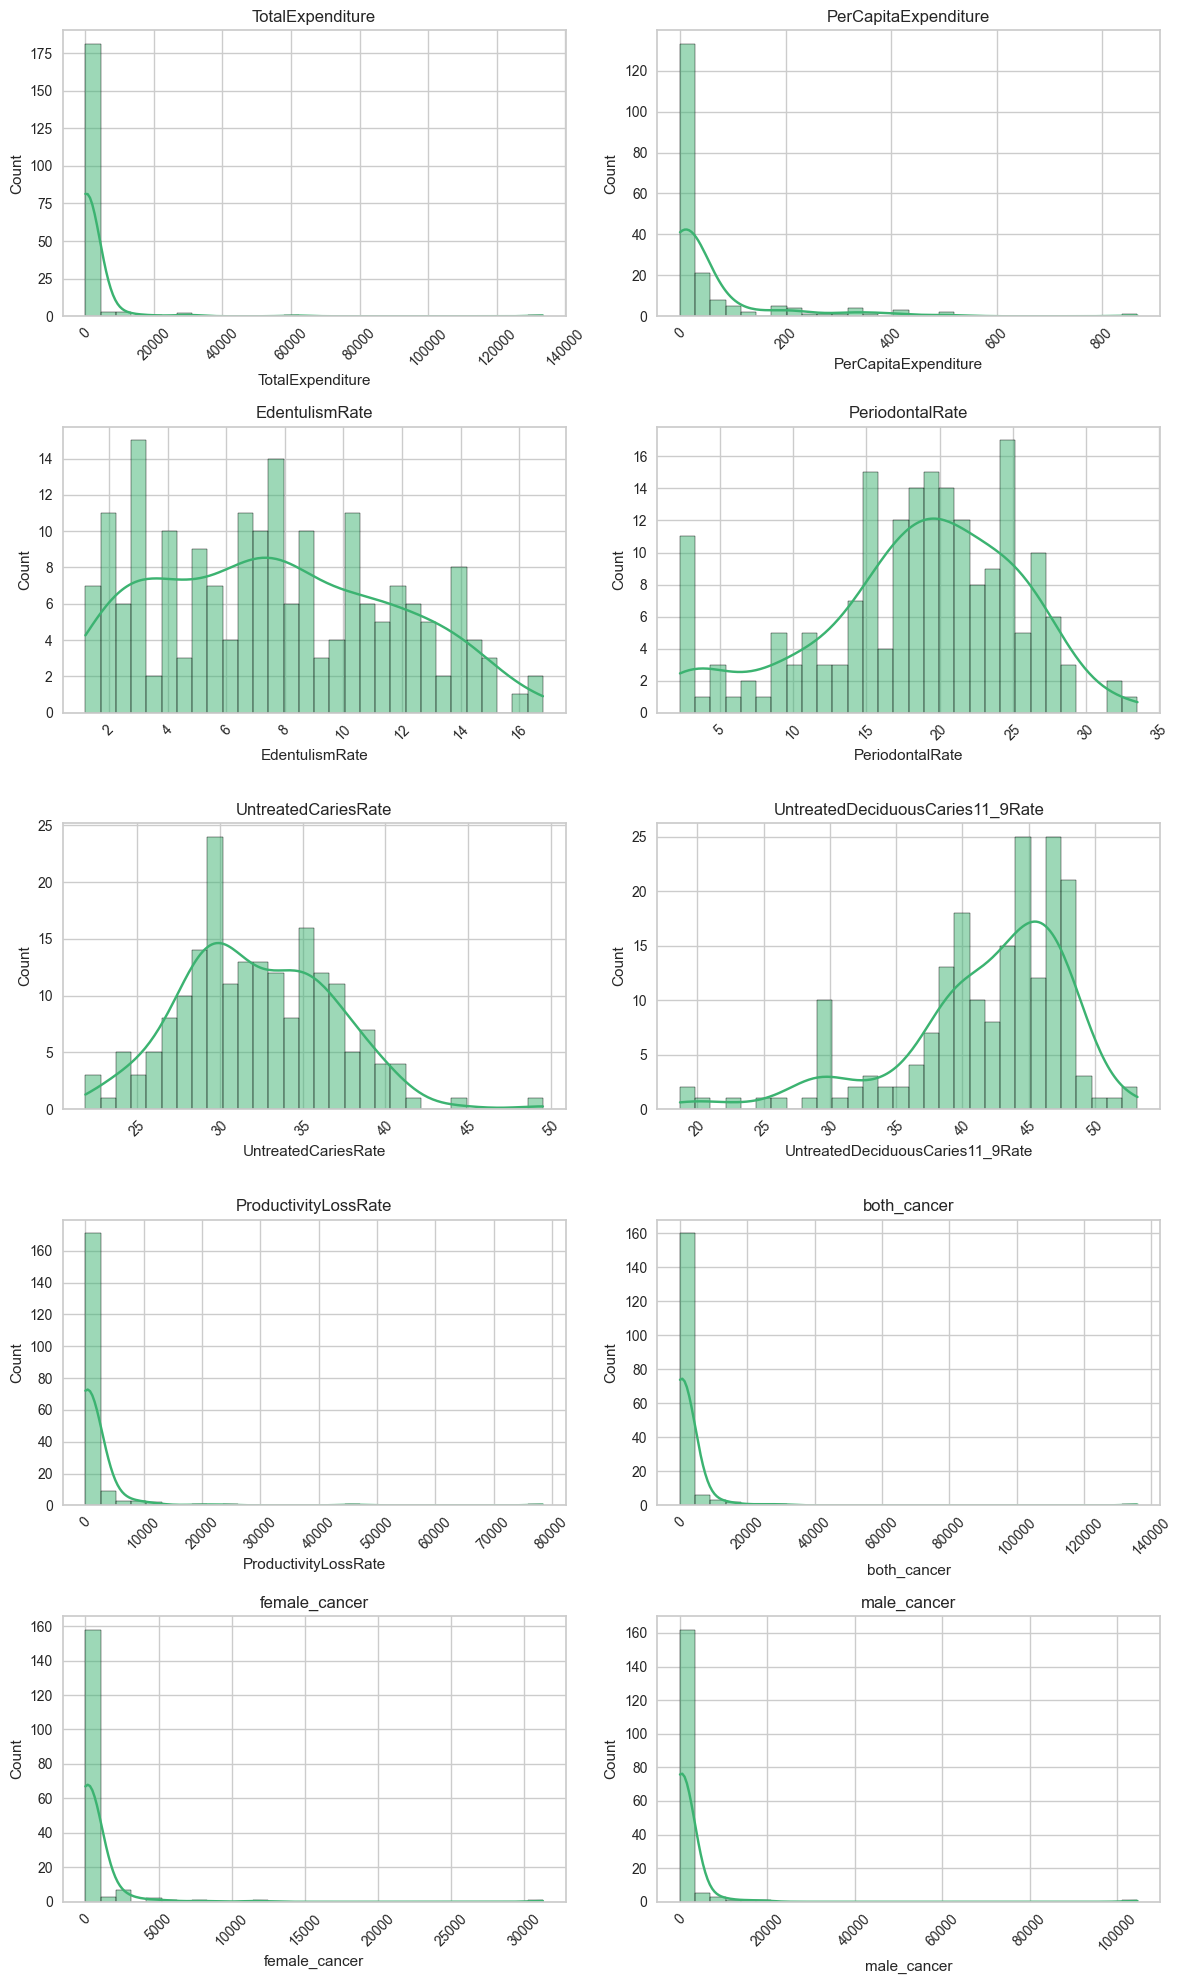

In [18]:
numeric_cols = [col for col in df.columns if col not in ['Period', 'Location']]
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    
    # Histogram + KDE (trendline)
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color='mediumseagreen', edgecolor='black')
    
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Fazla boş subplotları kaldır
if len(numeric_cols) % n_cols != 0:
    for j in range(len(numeric_cols), n_rows*n_cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [19]:
#En çok harcama yapan 10 ülke
top_total_expenditure = df.sort_values("TotalExpenditure", ascending=False).head(10)

print("En çok harcama yapan 10 ülke:")
print(top_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]].to_string(index=False))


En çok harcama yapan 10 ülke:
                                     Location  TotalExpenditure  PerCapitaExpenditure
                        UnitedStatesofAmerica          133505.8                 405.5
                                        China           61548.6                  44.0
                                      Germany           30877.3                 372.2
                                        Japan           28733.6                 227.7
                                        Italy           19123.0                 316.8
                                       Canada           12829.1                 342.5
                                       France           12666.0                 195.4
UnitedKingdomofGreatBritainandNorthernIreland            9576.9                 143.2
                                        Spain            8306.3                 178.0
                                    Australia            7370.3                 288.3


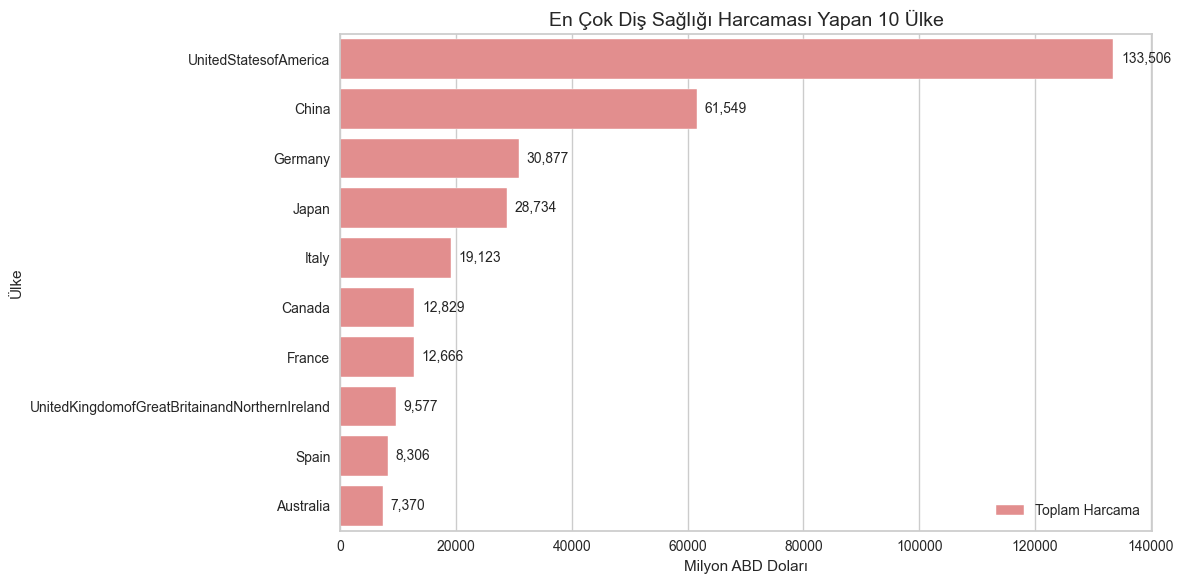

In [20]:
# En çok harcama yapan 10 ülkeyi seç
top_total_expenditure = df.sort_values("TotalExpenditure", ascending=False).head(10)

# Grafik boyutu ve stil
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Barplot
ax = sns.barplot(
    x="TotalExpenditure",
    y="Location",
    data=top_total_expenditure,
    color="lightcoral",
    label="Toplam Harcama"
)

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + (0.01 * top_total_expenditure["TotalExpenditure"].max()),  # barın biraz sağına
        p.get_y() + p.get_height() / 2,
        f"{width:,.0f}",  # sayıyı binlik ayırıcı ile yaz
        ha="left", va="center", fontsize=10
    )

# Başlık ve açıklamalar
plt.title("En Çok Diş Sağlığı Harcaması Yapan 10 Ülke", fontsize=14)
plt.xlabel("Milyon ABD Doları")
plt.ylabel("Ülke")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [21]:
# En düşük harcama yapan 10 ülke
low_total_expenditure = df.sort_values("TotalExpenditure", ascending=True).head(10)
print("\nEn düşük harcama yapan 10 ülke:")
print(low_total_expenditure[["Location", "TotalExpenditure", "PerCapitaExpenditure"]])


En düşük harcama yapan 10 ülke:
                     Location  TotalExpenditure  PerCapitaExpenditure
21                      Kenya               0.0                   0.0
31                      Niger               0.0                   0.0
18                     Gambia               0.0                   0.0
88                       Iraq               0.0                   0.0
173                  Cambodia               0.0                   0.0
157                    Bhutan               0.0                   0.1
42   UnitedRepublicofTanzania               0.1                   0.0
37         SaoTomeandPrincipe               0.1                   0.6
190                   Vanuatu               0.1                   0.5
188                    Tuvalu               0.1                   6.8


In [22]:
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate","ProductivityLossRate"]

# Ülkeleri toplam harcama sırasına göre göster
df_top_spenders_health = top_total_expenditure[["Location"] + health_cols]
print("\nEn çok harcama yapan 10 ülkenin sağlık göstergeleri:")

# Tek satırda göstermek için
print(df_top_spenders_health.to_string(index=False))



En çok harcama yapan 10 ülkenin sağlık göstergeleri:
                                     Location  EdentulismRate  PeriodontalRate  UntreatedCariesRate  UntreatedDeciduousCaries11_9Rate  ProductivityLossRate
                        UnitedStatesofAmerica            10.2             15.7                 24.3                              42.6               78468.5
                                        China             5.7             17.5                 24.6                              47.2               45713.1
                                      Germany            11.7             27.4                 31.7                              29.1               19395.9
                                        Japan            11.7             20.6                 25.8                              39.5               23663.0
                                        Italy            12.9             18.2                 29.6                              36.1                9541.6
          

C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\889393609.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


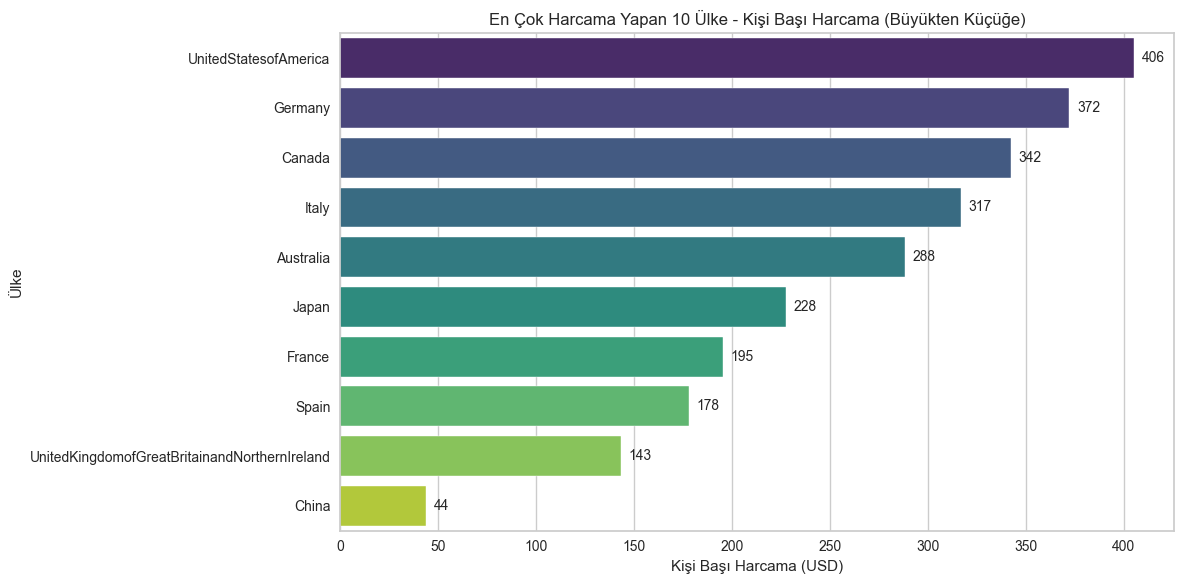

In [23]:
# Kişi başı harcamaya göre büyükten küçüğe sıralama
sorted_df = top_total_expenditure.sort_values("PerCapitaExpenditure", ascending=False)

# Grafik
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="PerCapitaExpenditure",
    y="Location",
    data=sorted_df,
    palette="viridis"
)

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + (0.01 * sorted_df["PerCapitaExpenditure"].max()),  # barın biraz sağına
        p.get_y() + p.get_height() / 2,
        f"{width:,.0f}",  # sayıyı binlik ayırıcı ile yaz
        ha="left", va="center", fontsize=10
    )

# Başlık ve eksenler
plt.title("En Çok Harcama Yapan 10 Ülke - Kişi Başı Harcama (Büyükten Küçüğe)")
plt.xlabel("Kişi Başı Harcama (USD)")
plt.ylabel("Ülke")
plt.tight_layout()
plt.show()


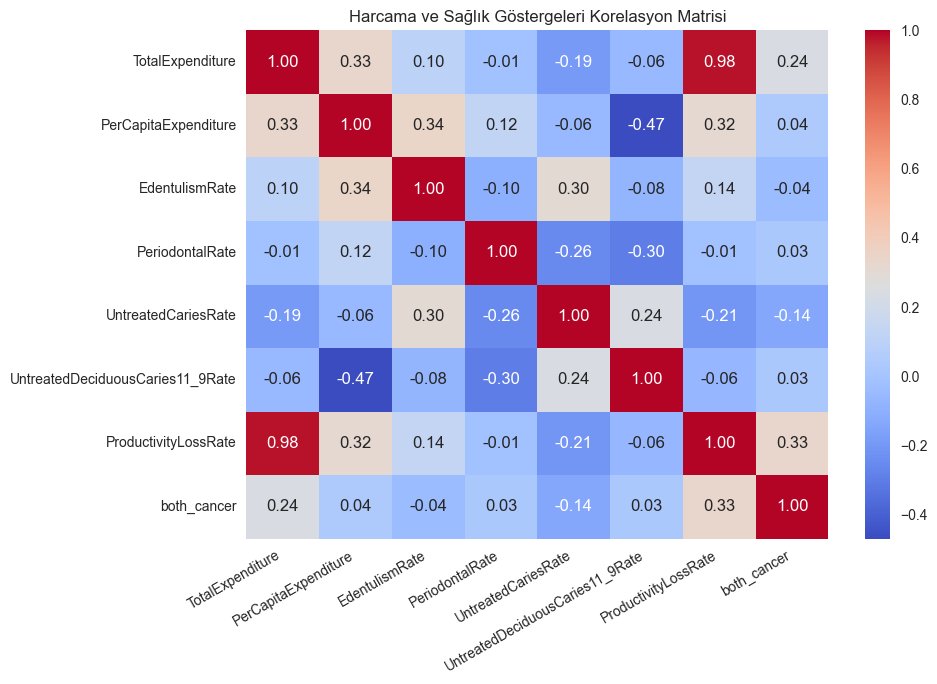

In [24]:
# Sayısal sütunları seç
numeric_for_corr = [col for col in df.columns if col not in ['Location','female_cancer', 'male_cancer']]

# Korelasyon matrisi
corr = df[numeric_for_corr].corr()

# Görselleştirme
plt.figure(figsize=(10, 7))
ax = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# X ekseni etiketlerini 45 derece döndür
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.title("Harcama ve Sağlık Göstergeleri Korelasyon Matrisi")
plt.tight_layout()
plt.show()


In [25]:

# TotalExpenditure'e göre 3 gruba ayır (Low, Medium, High)
df["ExpenditureGroup"] = pd.qcut(df["TotalExpenditure"], 3, labels=["Low", "Medium", "High"])

# Gruplara göre sağlık göstergelerinin ortalaması
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate"]


# Harcama gruplarına göre sağlık göstergelerinin ortalaması
grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()

# Daha okunaklı ve görsel olarak zengin tablo
styled_table = grouped_health.style\
    .format("{:.4f}")\
    .background_gradient(cmap="YlGnBu")\
    .set_caption("Harcama Gruplarına Göre Sağlık Göstergeleri Ortalamaları")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '14px'), ('font-weight', 'bold')]
    }])

styled_table

C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\515115935.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_health = df.groupby("ExpenditureGroup")[health_cols].mean()


,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate
ExpenditureGroup,,,,,
Low,4.4938,18.7016,31.6281,42.2219,37.3266
Medium,8.4453,17.7281,32.6078,43.0094,273.8547
High,9.9953,18.8891,32.5328,39.9703,4730.8000


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\4164158232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\4164158232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\4164158232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\4164158232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

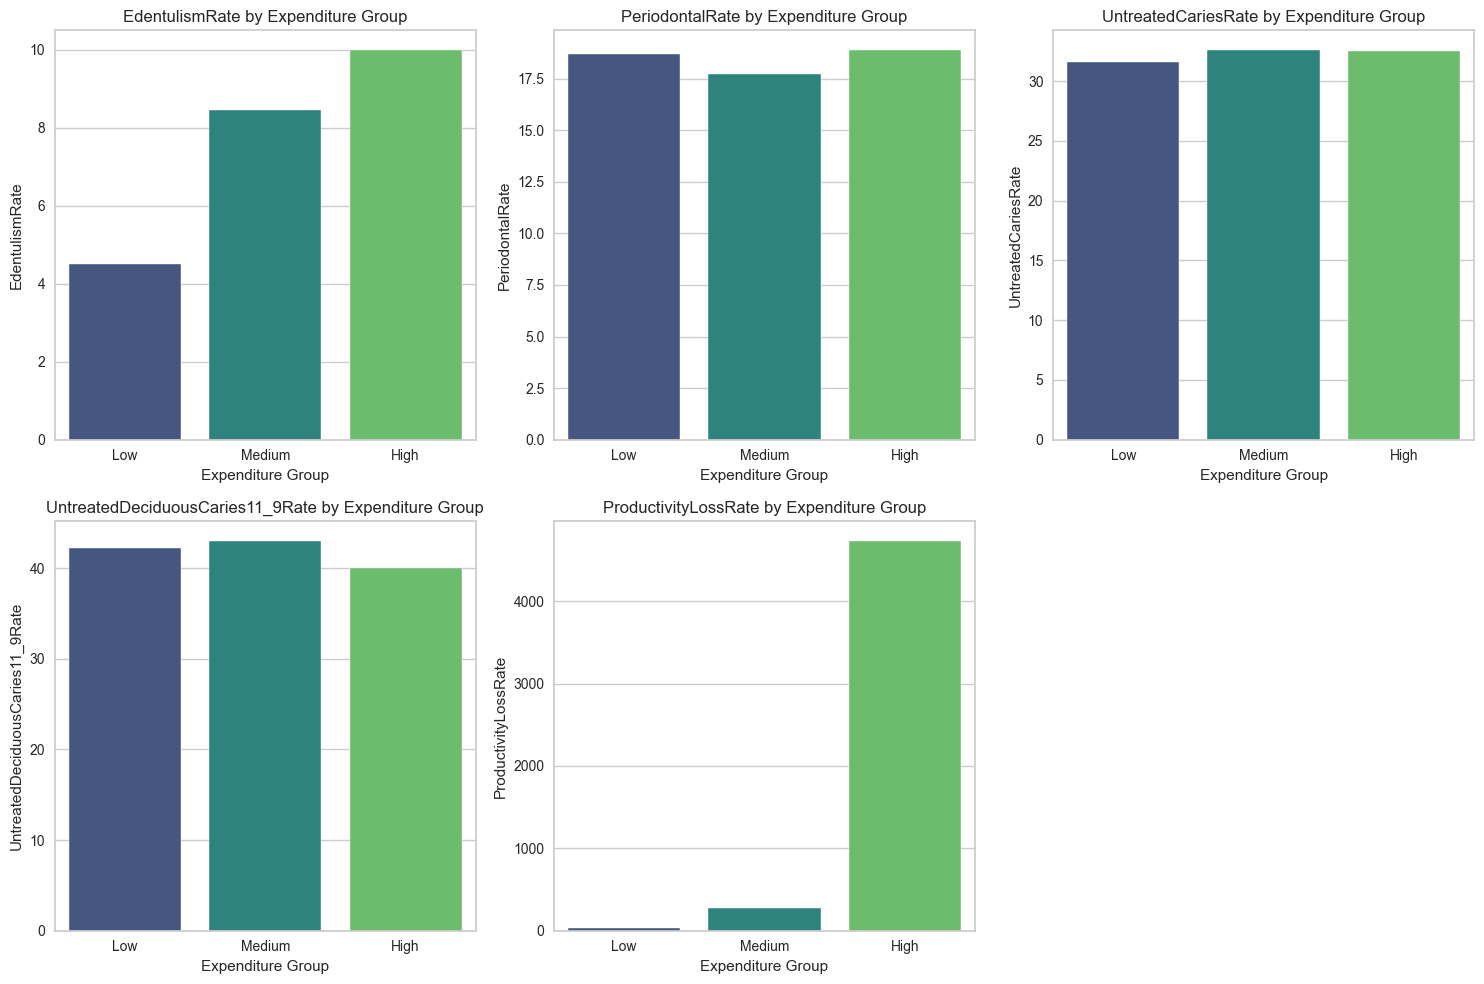

In [26]:
# Ayar: kaç sütun olsun
n_cols = 3
n_rows = (len(health_cols) + n_cols - 1) // n_cols  # Satır sayısını otomatik ayarla

# Grafik alanı
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

# axes'i her durumda düzleştir (tek subplot olsa bile listeye çevir)
if isinstance(axes, plt.Axes):
    axes = [axes]
else:
    axes = axes.flatten()

# Her gösterge için bar plot
for i, col in enumerate(health_cols):
    sns.barplot(
        x=grouped_health.index,
        y=grouped_health[col],
        palette="viridis",
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by Expenditure Group")
    axes[i].set_xlabel("Expenditure Group")
    axes[i].set_ylabel(col)

# Fazla boş eksenleri kaldır (varsa)
for j in range(len(health_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\654117084.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=top20_caries, palette="magma")


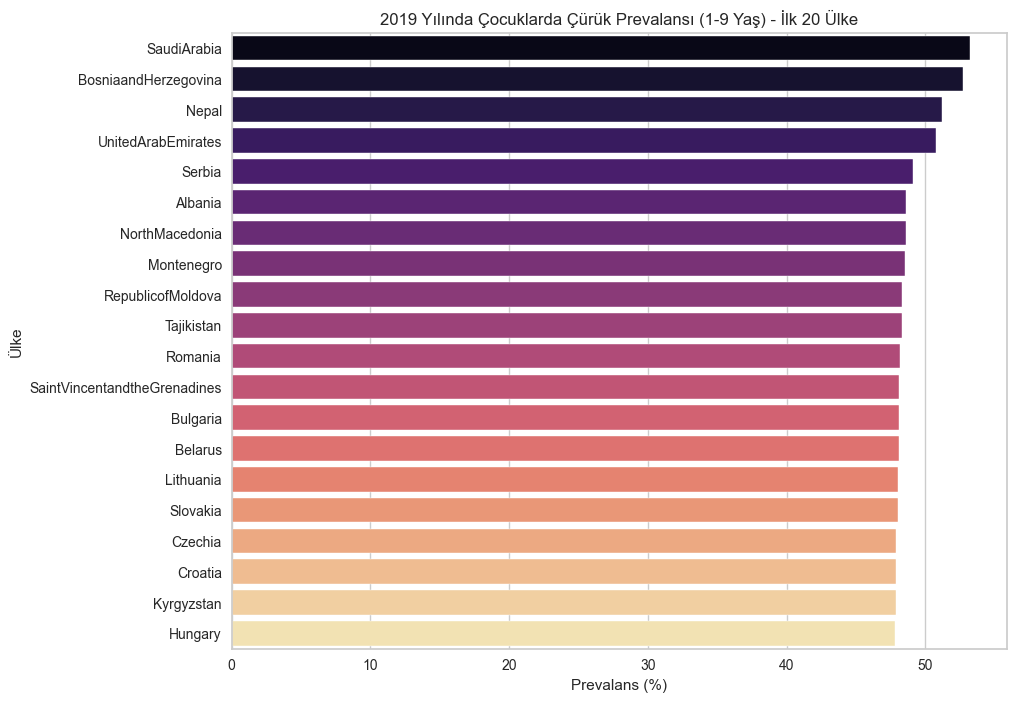

In [27]:
#2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke
# En yüksek 20 ülkeyi seç
top20_caries = df.nlargest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=top20_caries, palette="magma")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - İlk 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\592134809.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=bottom20_caries, palette="cool")


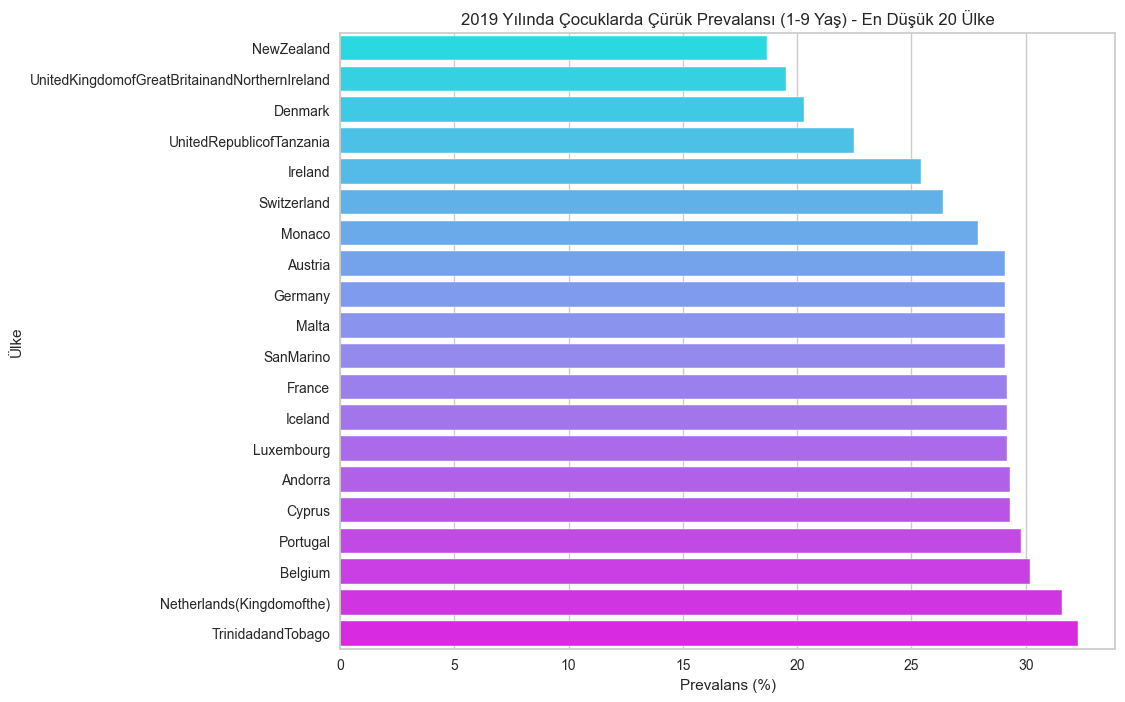

In [28]:
# En düşük 20 ülkeyi seç
bottom20_caries = df.nsmallest(20, "UntreatedDeciduousCaries11_9Rate")

plt.figure(figsize=(10,8))
sns.barplot(x="UntreatedDeciduousCaries11_9Rate", y="Location", data=bottom20_caries, palette="cool")
plt.title("2019 Yılında Çocuklarda Çürük Prevalansı (1-9 Yaş) - En Düşük 20 Ülke")
plt.xlabel("Prevalans (%)")
plt.ylabel("Ülke")
plt.show()


In [29]:
countries = ["Germany", "Türkiye"]
df_countries = df[df["Location"].isin(countries)]

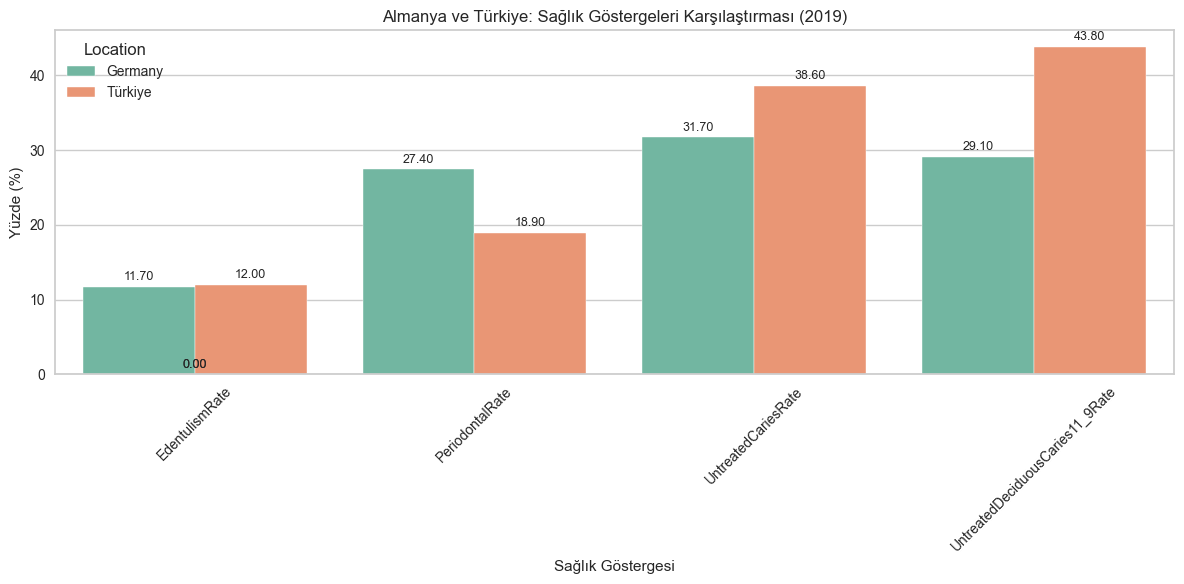

In [30]:
# Almanya ve Türkiye: Sağlık Göstergeleri Karşılaştırması (2019)
health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate"]

plt.figure(figsize=(12,6))
df_melted = df_countries.melt(id_vars=["Location"], value_vars=health_cols,
                              var_name="HealthIndicator", value_name="Value")

ax = sns.barplot(x="HealthIndicator", y="Value", hue="Location", data=df_melted, palette="Set2")

# Her barın üstüne değerleri yaz
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.5,  
            s=f'{height:.2f}',  
            ha='center', va='bottom', fontsize=9)

plt.title("Almanya ve Türkiye: Sağlık Göstergeleri Karşılaştırması (2019)")
plt.xlabel("Sağlık Göstergesi")
plt.ylabel("Yüzde (%)")  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

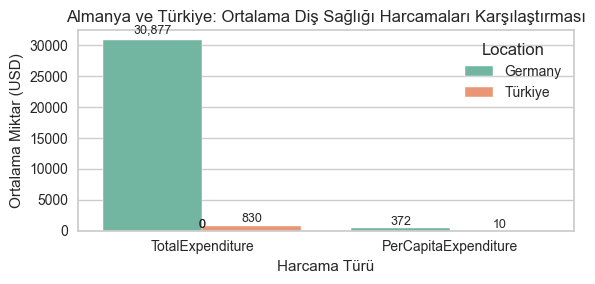

In [31]:
# Karşılaştırılacak değişkenler
expenditure_cols = ["TotalExpenditure", "PerCapitaExpenditure"]

# Almanya ve Türkiye için ortalama değerleri hesapla
df_avg = df_countries.groupby("Location")[expenditure_cols].mean().reset_index()

# Veriyi uzun formata çevir
df_avg_melted = df_avg.melt(
    id_vars="Location",
    value_vars=expenditure_cols,
    var_name="ExpenditureType",
    value_name="AverageValue"
)

# Grafik
plt.figure(figsize=(6, 3))
ax = sns.barplot(
    x="ExpenditureType",
    y="AverageValue",
    hue="Location",
    data=df_avg_melted,
    palette="Set2"
)

# Her barın üstüne Y değerlerini yaz
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2.,
        y=height + 0.02*height,  # barın biraz üstüne
        s=f'{height:,.0f}',       # tam sayı formatında
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title("Almanya ve Türkiye: Ortalama Diş Sağlığı Harcamaları Karşılaştırması")
plt.xlabel("Harcama Türü")
plt.ylabel("Ortalama Miktar (USD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\2193209519.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="both_cancer", y="Location", data=top15_cancer, palette="Reds")


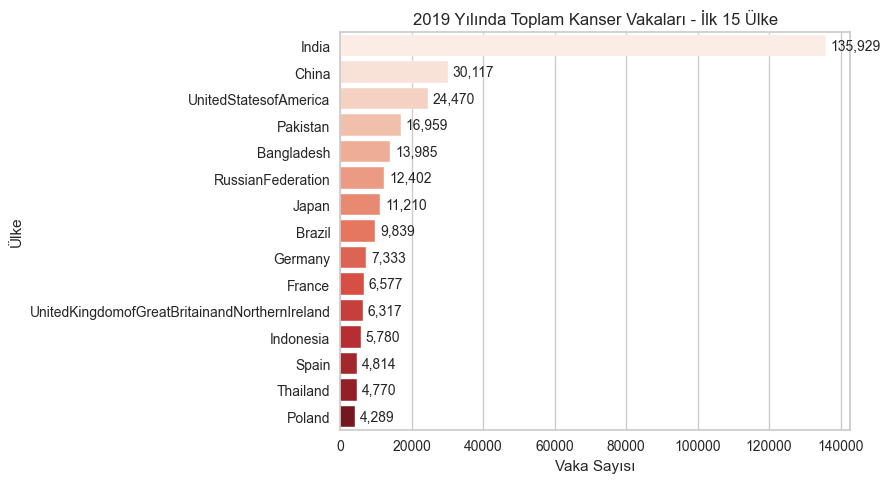

In [32]:
# Toplam kanser vaka sayısına göre ilk 15 ülke
top15_cancer = df.nlargest(15, "both_cancer")

plt.figure(figsize=(9,5))
ax = sns.barplot(x="both_cancer", y="Location", data=top15_cancer, palette="Reds")

# Çubukların üzerine değerleri ekle
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + (0.01 * top15_cancer["both_cancer"].max()),  # barın biraz sağına
        p.get_y() + p.get_height() / 2,
        f"{int(width):,}",  # binlik ayırıcı ile tam sayı
        ha="left", va="center", fontsize=10
    )

plt.title("2019 Yılında Toplam Kanser Vakaları - İlk 15 Ülke")
plt.xlabel("Vaka Sayısı")
plt.ylabel("Ülke")
plt.tight_layout()
plt.show()



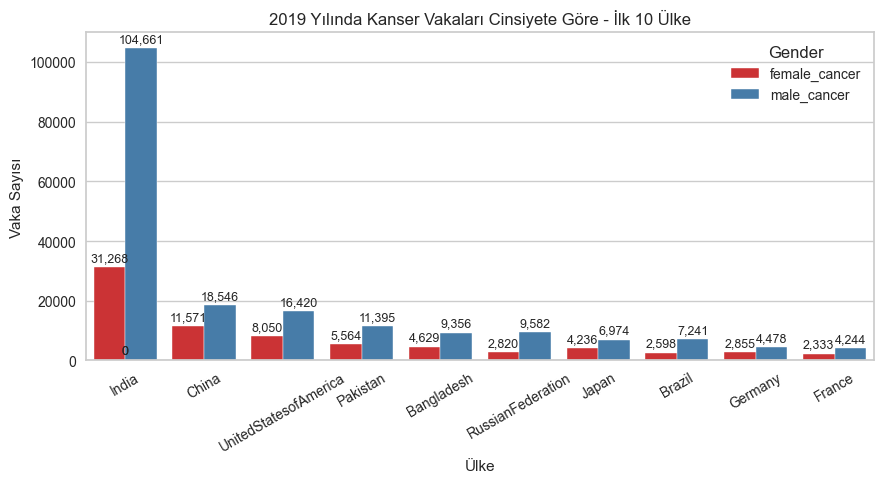

In [33]:
# Sadece ilk 10 ülke ile örnek
top10_cancer = df.nlargest(10, "both_cancer")
cancer_cols = ["female_cancer", "male_cancer"]

df_melted = top10_cancer.melt(
    id_vars=["Location"], value_vars=cancer_cols,
    var_name="Gender", value_name="Cases"
)

plt.figure(figsize=(9,5))
ax = sns.barplot(x="Location", y="Cases", hue="Gender", data=df_melted, palette="Set1")

# Çubukların üzerine değer yazma
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2.,  # barın ortasına hizala
        height + (0.01 * df_melted["Cases"].max()),  # biraz yukarısına yaz
        f"{int(height):,}",  # binlik ayraçlı sayı
        ha="center", va="bottom", fontsize=9
    )

plt.title("2019 Yılında Kanser Vakaları Cinsiyete Göre - İlk 10 Ülke")
plt.xlabel("Ülke")
plt.ylabel("Vaka Sayısı")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


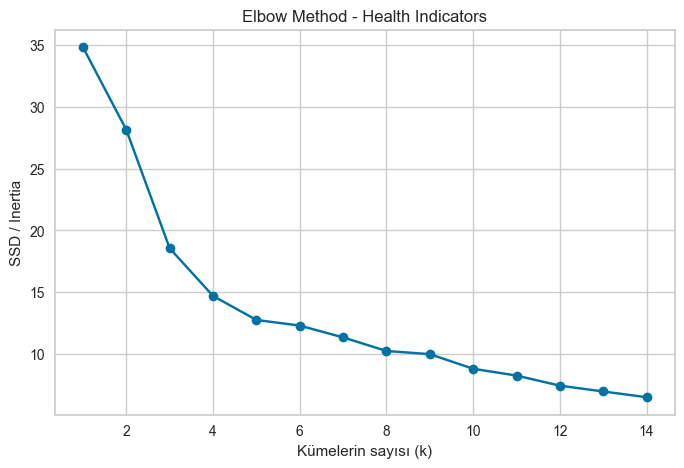

In [34]:
#Ağız Sağlığı Küme Profilleri (K-means)

health_cols = ["EdentulismRate", "PeriodontalRate", "UntreatedCariesRate",
               "UntreatedDeciduousCaries11_9Rate", "ProductivityLossRate"]

# Ölçekleme
scaler = MinMaxScaler()
X_health_scaled = scaler.fit_transform(df[health_cols])

# Elbow Method için SSD hesaplama
ssd = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_health_scaled)   # Fit et
    ssd.append(kmeans.inertia_)   # SSD'yi ekle

# Görselleştirme
plt.figure(figsize=(8,5))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Kümelerin sayısı (k)')
plt.ylabel('SSD / Inertia')
plt.title('Elbow Method - Health Indicators')
plt.show()

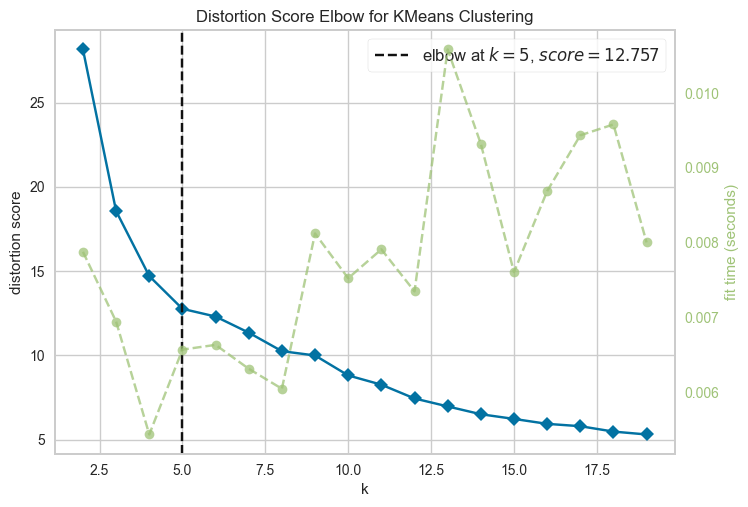

Optimal küme sayısı: 5


In [35]:
# Ölçekleme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[health_cols])

# KMeans modeli
kmeans = KMeans(random_state=42)

# K-Elbow (2-20 arasında K denemesi)
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(X_scaled) 
elbow.show()

# Optimal K
print("Optimal küme sayısı:", elbow.elbow_value_)

In [36]:
# Ölçekleme
scaler = MinMaxScaler()
X_health_scaled = scaler.fit_transform(df[health_cols])

# KMeans fit
kmeans = KMeans(n_clusters=elbow.elbow_value_,random_state=42)
kmeans.fit(X_health_scaled)

# Küme sayısı
print("Küme sayısı:", kmeans.n_clusters)

# Küme merkezleri (ölçeklenmiş değerler)
print("Küme merkezleri:\n", kmeans.cluster_centers_)

# Her verinin etiketi (hangi segmentte olduğu)
df["kmeans_cluster_no"] = kmeans.labels_ + 1

# İlk 5 satır
df.head()

Küme sayısı: 5
Küme merkezleri:
 [[0.38286713 0.61400058 0.30344203 0.714361   0.04516839]
 [0.29487179 0.17775468 0.39385037 0.76788092 0.00375052]
 [0.09722222 0.70474664 0.29408213 0.61297447 0.00336623]
 [0.6811491  0.56813865 0.36486849 0.3324745  0.04997081]
 [0.69261294 0.49496337 0.5218254  0.8005521  0.01179283]]


,Location,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer,ExpenditureGroup,kmeans_cluster_no
0,Angola,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482.0,166.0,316.0,Medium,3
1,Burundi,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92.0,30.0,62.0,Low,3
2,Benin,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74.0,42.0,32.0,Low,3
3,BurkinaFaso,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179.0,55.0,124.0,Low,3
4,Botswana,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60.0,8.0,52.0,Medium,1


In [37]:
# Sadece sayısal sütunlar
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# kmeans_cluster_no'yu çıkar
if "kmeans_cluster_no" in numeric_cols:
    numeric_cols.remove("kmeans_cluster_no")

# Küme bazlı özet
summary = df.groupby("kmeans_cluster_no")[numeric_cols].agg(["count","mean","median"])

# Multi-index sütunları düzleştir
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

# Daha okunaklı yapmak için sayıları yuvarla
summary = summary.round(1)

# Göster
summary


,TotalExpenditure_count,TotalExpenditure_mean,TotalExpenditure_median,PerCapitaExpenditure_count,PerCapitaExpenditure_mean,PerCapitaExpenditure_median,EdentulismRate_count,EdentulismRate_mean,EdentulismRate_median,PeriodontalRate_count,...,ProductivityLossRate_median,both_cancer_count,both_cancer_mean,both_cancer_median,female_cancer_count,female_cancer_mean,female_cancer_median,male_cancer_count,male_cancer_mean,male_cancer_median
kmeans_cluster_no,,,,,,,,,,,,,,,,,,,,,
1,44,5202.2,62.0,44,57.6,23.7,44,7.2,7.4,44,...,118.7,38,2091.1,92.5,38,782.9,32.0,38,1308.2,53.5
2,37,288.9,6.9,37,11.6,3.5,37,5.8,6.0,37,...,37.0,29,739.1,277.0,29,255.8,138.0,29,483.4,126.0
3,42,10.8,2.9,42,0.6,0.2,42,2.7,2.8,42,...,26.0,41,4280.6,166.0,41,1100.7,55.0,41,3180.0,74.0
4,27,4781.9,826.5,27,225.4,195.4,27,11.8,11.7,27,...,1384.4,24,1947.9,584.0,24,738.8,199.0,24,1209.2,354.0
5,42,427.1,123.6,42,35.0,15.8,42,12.0,12.0,42,...,312.5,42,1106.8,261.5,42,298.7,101.5,42,808.1,178.0


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\2698009557.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='kmeans_cluster_no', data=df, palette='Set2')


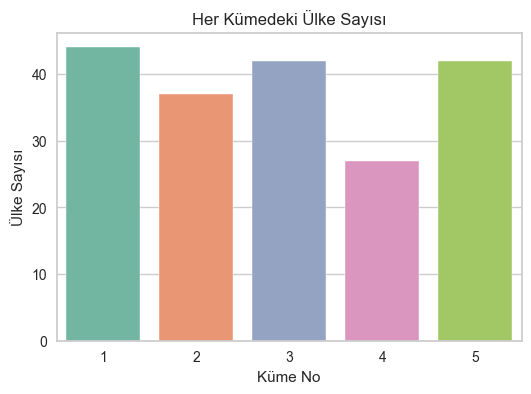

In [ ]:

# Countplot
plt.figure(figsize=(6,4))
sns.countplot(x='kmeans_cluster_no', data=df, palette='Set2')
plt.title("Her Kümedeki Ülke Sayısı")
plt.xlabel("Küme No")
plt.ylabel("Ülke Sayısı")
plt.show()


In [39]:
# Küme bazında ülkeler
cluster_countries = df.groupby("kmeans_cluster_no")["Location"].apply(list)
cluster_countries

kmeans_cluster_no
1    [Botswana, CentralAfricanRepublic, Lesotho, Es...
2    [Mauritius, SierraLeone, Seychelles, Afghanist...
3    [Angola, Burundi, Benin, BurkinaFaso, Coted'Iv...
4    [Namibia, Colombia, TrinidadandTobago, Andorra...
5    [Algeria, Bolivia(PlurinationalStateof), Brazi...
Name: Location, dtype: object

In [40]:
# Küme bazında ortalama değerler
cluster_means = df.groupby("kmeans_cluster_no")[numeric_cols].mean()
cluster_means

,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer
kmeans_cluster_no,,,,,,,,,,
1,5202.229545,57.565909,7.172727,21.456818,30.275000,43.345455,3544.390909,2091.105263,782.894737,1308.210526
2,288.929730,11.605405,5.800000,7.845946,32.770270,45.191892,294.397297,739.137931,255.758621,483.379310
3,10.807143,0.602381,2.716667,24.288095,30.016667,39.847619,264.242857,4280.609756,1100.658537,3179.951220
4,4781.881481,225.388889,11.825926,20.025926,31.970370,30.170370,3921.229630,1947.916667,738.750000,1209.166667
5,427.126190,35.033333,12.004762,17.742857,36.302381,46.319048,925.464286,1106.809524,298.714286,808.095238


In [41]:
# Her kümedeki ülkeleri listele
clusters_countries = df.groupby("kmeans_cluster_no")["Location"].apply(list)

# Her kümeyi tek tek yazdıralım
for cluster, countries in clusters_countries.items():
    print(f"\n📌 Küme {cluster} ({len(countries)} ülke):")
    print(", ".join(countries))


📌 Küme 1 (44 ülke):
Botswana, CentralAfricanRepublic, Lesotho, Eswatini, SouthAfrica, Zimbabwe, Argentina, AntiguaandBarbuda, Bahamas, Belize, Barbados, Canada, CostaRica, Dominica, DominicanRepublic, Grenada, Guatemala, Guyana, Honduras, Haiti, Jamaica, SaintKittsandNevis, SaintLucia, Mexico, Nicaragua, Panama, Paraguay, ElSalvador, Suriname, UnitedStatesofAmerica, SaintVincentandtheGrenadines, Venezuela(BolivarianRepublicof), UnitedArabEmirates, Bahrain, Egypt, Iran(IslamicRepublicof), Kuwait, Libya, Qatar, Indonesia, Thailand, China, RepublicofKorea, Singapore

📌 Küme 2 (37 ülke):
Mauritius, SierraLeone, Seychelles, Afghanistan, Iraq, Jordan, Oman, SaudiArabia, Sudan, Yemen, Spain, Tajikistan, Uzbekistan, SriLanka, Maldives, Myanmar, Nepal, DemocraticPeople'sRepublicofKorea, Timor-Leste, BruneiDarussalam, Fiji, Micronesia(FederatedStatesof), Cambodia, Kiribati, LaoPeople'sDemocraticRepublic, MarshallIslands, Malaysia, Nauru, Philippines, Palau, PapuaNewGuinea, SolomonIslands, Tonga

📌 Küme 1 (44 ülke)

Ülkeler: Afrika’nın güneyi (Botswana, Güney Afrika, Zimbabve), Kuzey Afrika’dan bazı ülkeler (Mısır, Libya), Kuzey Amerika (ABD, Kanada, Meksika), Orta Amerika ve Karayipler (Dominik, Jamaika, Küba hariç birçok ada ülkesi), Güney Amerika’dan Arjantin, Venezuela, Paraguay, Asya’dan Çin, Kore, Endonezya, Tayland, Singapur, Körfez ülkeleri (BAE, Katar, Kuveyt, Bahreyn).

Genel Özellik:

Yüksek sağlık harcamaları, görece daha iyi ağız sağlığı, güçlü ekonomi ve sağlık altyapısı.

ABD, Kanada, Singapur, Çin gibi yüksek gelirli ülkeler ile bazı petrol zengini Orta Doğu ülkeleri aynı kümeye düşmüş.

Küme 1 (ABD, Çin, Körfez, vs.)

Çok yüksek sağlık harcaması (5202), ama kişi başı düşük (57.6) → büyük nüfuslu ülkeler (Çin, ABD).

Ağız sağlığı orta düzeyde (Edentulism %7.1).

Kanser yükü yüksek (2091).

📌 Küme 2 (37 ülke)

Ülkeler: Güney Asya (Afganistan, Nepal, Sri Lanka), Orta Asya (Tacikistan, Özbekistan), Ortadoğu (Irak, Yemen, Suudi Arabistan), Güneydoğu Asya ve Pasifik ülkeleri (Malezya, Filipinler, Fiji, Vietnam).

Genel Özellik:

Orta gelir grubu, sağlık göstergeleri ve harcama seviyeleri orta seviyede.

Sağlık sistemleri gelişmekte, ancak bölgesel eşitsizlikler mevcut.

Küme 2 (Ortadoğu + Pasifik + Asya gelişmekte)

Düşük harcama (289 toplam, kişi başı 11.6).

Ağız sağlığı görece iyi (Edentulism %5.8, Periodontal %7.8).

Kanser yükü düşük (739).

📌 Küme 3 (42 ülke)

Ülkeler: Büyük oranda Afrika ülkeleri (Kenya, Nijerya, Tanzanya, Etiyopya, Senegal, vs.), ayrıca Pakistan, Hindistan, Bangladeş, Bhutan.

Genel Özellik:

Düşük sağlık harcaması, ağız sağlığı sorunları daha yüksek.

Gelişmekte olan ve düşük gelirli ülkeler.

En kırılgan grup diyebiliriz.

Küme 3 (Afrika + Hindistan, Pakistan)

Çok düşük harcama (10.8 toplam, kişi başı 0.6).

Edentulism düşük (%2.7) ama bu sağlık hizmeti yetersizliğinden olabilir (raporlanmamış vaka olasılığı).

Periodontal çok yüksek (%24) → ciddi sorun.

Kanser yükü çok yüksek (4280, erkeklerde 3180!) → sağlık hizmetlerine erişim düşük.

📌 Küme 4 (27 ülke)

Ülkeler: Avrupa Birliği ve Batı Avrupa ülkeleri (Almanya, Fransa, İtalya, İskandinav ülkeleri, Benelüks), ayrıca Avustralya, Japonya, Yeni Zelanda.

Genel Özellik:

En gelişmiş sağlık sistemleri, yüksek kişi başı sağlık harcaması.

Ağız sağlığı göstergeleri en iyi seviyede.

Bu küme aslında yüksek gelirli OECD ülkeleri kümesi.

Küme 4 (Batı Avrupa + OECD)

Çok yüksek harcama (4781, kişi başı 225).

Edentulism en yüksek (%11.8) → yaşlı nüfus etkisi.

Kanser yükü orta (1947).

Sağlık sistemi güçlü ama yaşlanma kaynaklı ağız sağlığı sorunları artıyor.

📌 Küme 5 (42 ülke)

Ülkeler: Doğu Avrupa (Rusya, Ukrayna, Polonya, Romanya, Balkan ülkeleri), Kuzey Afrika (Cezayir, Tunus, Fas), Latin Amerika (Brezilya, Şili, Peru, Uruguay), Türkiye, İsrail, İsveç, Kazakistan.

Genel Özellik:

Orta-yüksek harcama düzeyi, ağız sağlığı bazı alanlarda iyi ama batı ülkeleri kadar değil.

Geçiş ekonomileri ve “orta-üst gelir” ülkeleri diyebiliriz.

Küme 5 (Doğu Avrupa + Latin Amerika + Türkiye)

Orta harcama (427 toplam, kişi başı 35).

Edentulism yüksek (%12) → ağız sağlığı zayıf.

Periodontal ve caries oranları yüksek.

Kanser yükü orta (1106).

Küme 3: En düşük gelişmişlik (Afrika + Güney Asya)

Küme 2: Orta gelişmişlik (Ortadoğu + Güneydoğu Asya + Pasifik)

Küme 5: Orta-üst gelişmişlik (Doğu Avrupa + Latin Amerika + Türkiye)

Küme 1: Yüksek gelişmişlik (ABD, Kanada, Çin, petrol zengini Orta Doğu, bazı Latin Amerika ülkeleri)

Küme 4: En yüksek gelişmişlik (Batı Avrupa + OECD ülkeleri)

En fakir küme: Küme 3 (Afrika + Güney Asya)

En zengin küme: Küme 4 (OECD ülkeleri)

Geçiş ülkeleri: Küme 5 (Doğu Avrupa, Türkiye, Latin Amerika)

Özel karışık grup: Küme 1 (ABD, Çin, petrol zengini ülkeler)

Orta gelişmişlik: Küme 2 (Ortadoğu + Pasifik ülkeleri)


Karşılaştırma:
                                   Germany  Cluster_Avg
TotalExpenditure                  30877.3       4781.9
PerCapitaExpenditure                372.2        225.4
EdentulismRate                       11.7         11.8
PeriodontalRate                      27.4         20.0
UntreatedCariesRate                  31.7         32.0
UntreatedDeciduousCaries11_9Rate     29.1         30.2
ProductivityLossRate              19395.9       3921.2
both_cancer                        7333.0       1947.9
female_cancer                      2855.0        738.8
male_cancer                        4478.0       1209.2


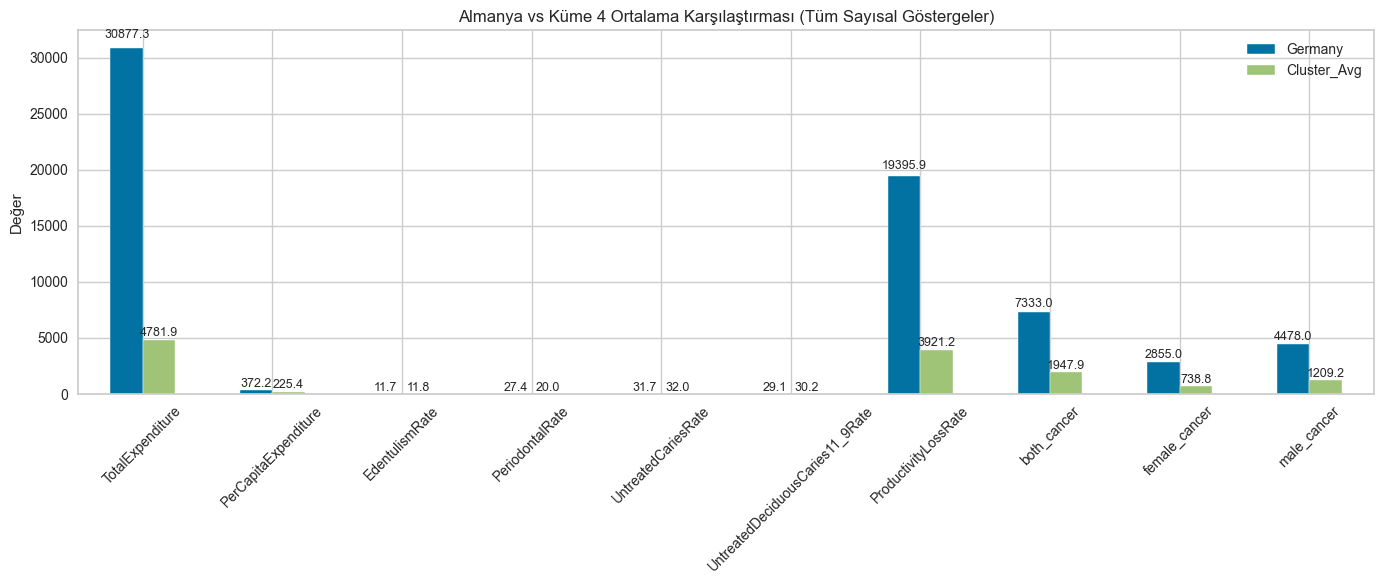

In [42]:
# Tüm sayısal sütunlar
numerical_cols = df.select_dtypes(include="number").columns.tolist()
numerical_cols.remove("kmeans_cluster_no")  # Küme etiketi karşılaştırmaya dahil olmasın

# Almanya'nın değerleri
germany_values = df[df["Location"] == "Germany"][numerical_cols]

# Almanya'nın küme numarası
germany_cluster = df[df["Location"] == "Germany"]["kmeans_cluster_no"].values[0]

# Küme ortalamaları
cluster_mean = df[df["kmeans_cluster_no"] == germany_cluster][numerical_cols].mean()

# Karşılaştırma tablosu ve yuvarlama
comparison = pd.DataFrame({
    "Germany": germany_values.values.flatten(),
    "Cluster_Avg": cluster_mean.values
}, index=numerical_cols).round(1)

print("\nKarşılaştırma:\n", comparison)

# Görselleştirme - Barplot
ax = comparison.plot(kind="bar", figsize=(14,6))

# Barların üstüne değerleri yaz
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.02*height,
            s=f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)

plt.title(f"Almanya vs Küme {germany_cluster} Ortalama Karşılaştırması (Tüm Sayısal Göstergeler)")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

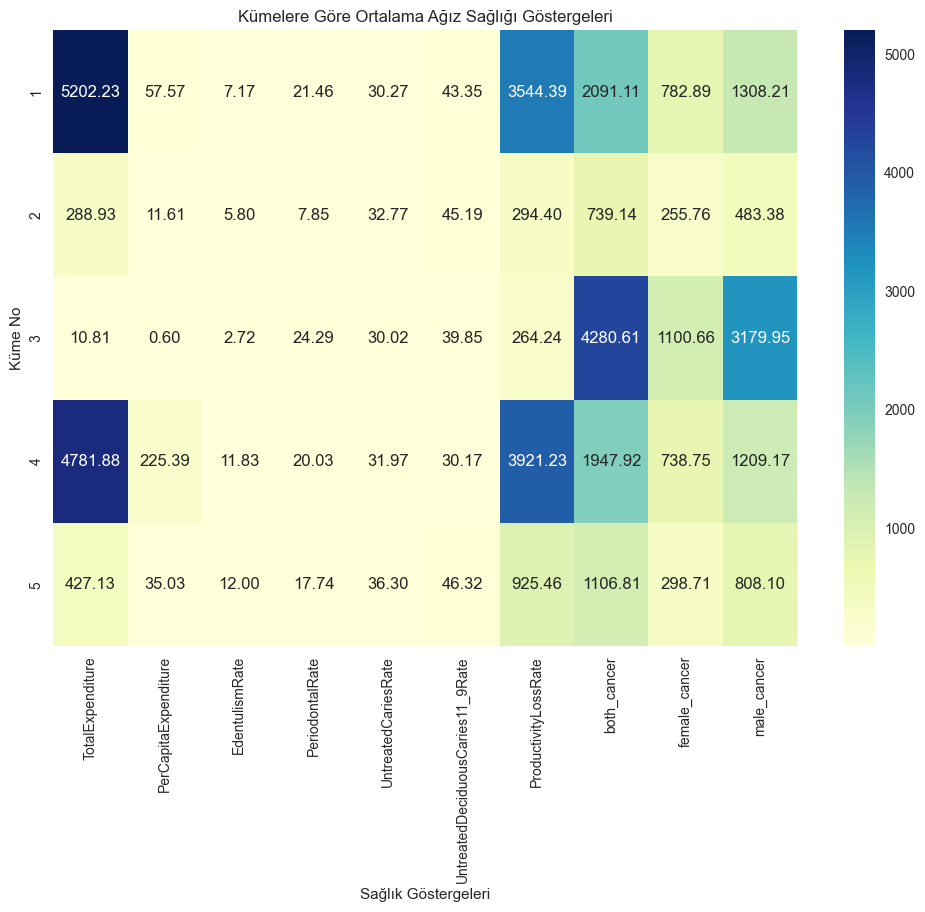

In [43]:
# Sadece sayısal sütunlar
num_cols = df.select_dtypes(include='number').columns.drop('kmeans_cluster_no')

# Küme bazında ortalamalar
cluster_means_health = df.groupby("kmeans_cluster_no")[num_cols].mean()

# Heatmap görselleştirme
plt.figure(figsize=(12,8))
sns.heatmap(cluster_means_health, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Kümelere Göre Ortalama Ağız Sağlığı Göstergeleri")
plt.xlabel("Sağlık Göstergeleri")
plt.ylabel("Küme No")
plt.show()

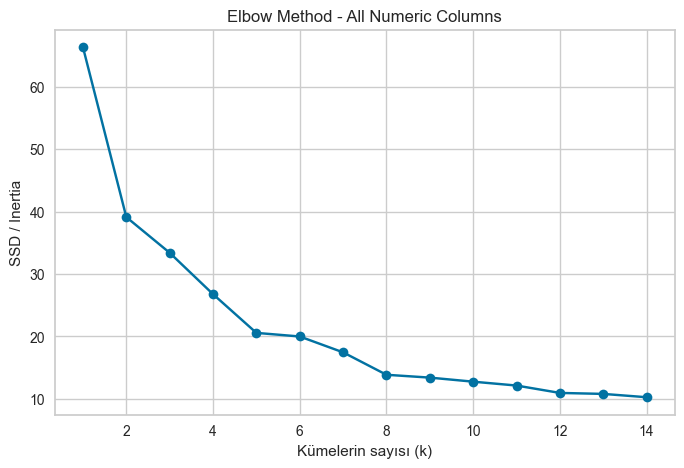

In [44]:
#Agiz kanseri dahil Kmeans kümeleme (eksik deger satirlari silindi)

# Tüm sayısal sütunları seç
numeric_cols = df.select_dtypes(include=np.number).columns

# NaN değerleri temizle
df_numeric = df[numeric_cols].dropna()

# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# Elbow Method için SSD hesaplama
ssd = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Xall_scaled)
    ssd.append(kmeans.inertia_)

# Görselleştirme
plt.figure(figsize=(8,5))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Kümelerin sayısı (k)')
plt.ylabel('SSD / Inertia')
plt.title('Elbow Method - All Numeric Columns')
plt.show()

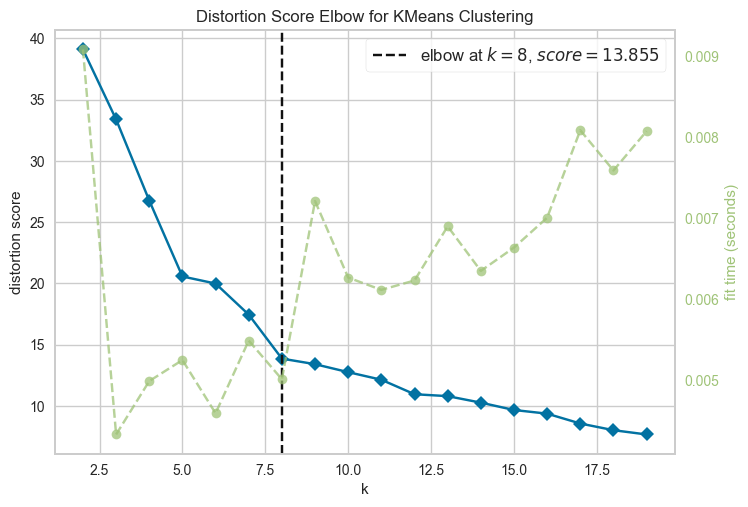

Optimal küme sayısı: 8


In [45]:
# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# KMeans modeli
kmeans = KMeans(random_state=42)

# K-Elbow (2-20 arasında K denemesi)
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(Xall_scaled)
elbow.show()

# Optimal K
print("Optimal küme sayısı:", elbow.elbow_value_)

In [46]:
# Ölçekleme
scaler = MinMaxScaler()
Xall_scaled = scaler.fit_transform(df_numeric)

# KMeans fit
kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=42)
kmeans.fit(Xall_scaled)

# Küme sayısı
print("Küme sayısı:", kmeans.n_clusters)

# Küme merkezleri (ölçeklenmiş değerler)
print("Küme merkezleri:\n", kmeans.cluster_centers_)

# Her verinin etiketi (hangi segmentte olduğu)
df_numeric["kmeans_cluster_no"] = kmeans.labels_ + 1

# İlk 5 satır
df_numeric.head()

Küme sayısı: 8
Küme merkezleri:
 [[1.93069454e-02 1.00896002e-01 3.76992377e-01 6.03170478e-01
  3.09341951e-01 7.06071289e-01 2.66587528e-02 1.09196133e-02
  1.87567637e-02 8.58765320e-03 1.11022302e-16]
 [1.62761583e-02 1.78466319e-01 6.67652860e-01 5.13313609e-01
  3.96599777e-01 3.30434783e-01 3.12985874e-02 9.56225938e-03
  1.56857342e-02 7.74228638e-03 7.69230769e-01]
 [7.28994546e-05 1.19926199e-03 9.48717949e-02 7.02884615e-01
  2.95108696e-01 6.11086957e-01 1.20445845e-03 7.26419328e-03
  1.10808174e-02 6.13343207e-03 5.00000000e-01]
 [2.75992142e-03 2.26692830e-02 2.88019452e-01 2.10764810e-01
  3.76436782e-01 7.57921039e-01 4.76173275e-03 5.42304274e-03
  8.17956443e-03 4.60901309e-03 2.50000000e-01]
 [2.38497129e-03 4.57661682e-02 6.95512821e-01 4.94551282e-01
  5.23097826e-01 8.11666667e-01 1.12264359e-02 8.37122132e-03
  9.67522707e-03 7.99111408e-03 1.00000000e+00]
 [6.10802619e-02 6.18551773e-01 7.01183432e-01 6.07248521e-01
  3.55351171e-01 3.81716834e-01 7.58910873e-0

,TotalExpenditure,PerCapitaExpenditure,EdentulismRate,PeriodontalRate,UntreatedCariesRate,UntreatedDeciduousCaries11_9Rate,ProductivityLossRate,both_cancer,female_cancer,male_cancer,kmeans_cluster_no
0,70.2,2.3,4.0,23.9,27.2,37.8,195.8,482.0,166.0,316.0,3
1,1.3,0.1,2.0,19.2,31.7,41.6,5.3,92.0,30.0,62.0,3
2,3.3,0.3,2.9,27.1,29.5,39.6,30.0,74.0,42.0,32.0,3
3,4.6,0.2,1.9,27.4,27.5,40.3,30.8,179.0,55.0,124.0,3
4,57.4,24.1,7.5,26.3,32.7,37.6,59.2,60.0,8.0,52.0,1


In [47]:
# Sayısal sütunlar
numeric_cols = df_numeric.select_dtypes(include=np.number).columns.tolist()

# kmeans_cluster_no'yu çıkar
if "kmeans_cluster_no" in numeric_cols:
    numeric_cols.remove("kmeans_cluster_no")

# Küme bazlı özet
cluster_summary = df_numeric.groupby("kmeans_cluster_no")[numeric_cols].agg(["count", "mean", "median"])

# Multi-index sütunları düzleştir
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Daha okunaklı yapmak için sayıları yuvarla
cluster_summary = cluster_summary.round(1)

# Göster
cluster_summary



,TotalExpenditure_count,TotalExpenditure_mean,TotalExpenditure_median,PerCapitaExpenditure_count,PerCapitaExpenditure_mean,PerCapitaExpenditure_median,EdentulismRate_count,EdentulismRate_mean,EdentulismRate_median,PeriodontalRate_count,...,ProductivityLossRate_median,both_cancer_count,both_cancer_mean,both_cancer_median,female_cancer_count,female_cancer_mean,female_cancer_median,male_cancer_count,male_cancer_mean,male_cancer_median
kmeans_cluster_no,,,,,,,,,,,,,,,,,,,,,
1,37,2577.6,82.3,37,52.0,16.7,37,7.1,7.5,37,...,220.4,37,1486.3,89.0,37,586.5,32.0,37,899.8,53.0
2,13,2173.0,593.7,13,91.9,91.6,13,11.6,12.0,13,...,1132.8,13,1301.8,317.0,13,490.5,115.0,13,811.3,208.0
3,40,9.7,2.9,40,0.6,0.2,40,2.7,2.7,40,...,26.0,40,989.4,144.5,40,346.5,54.0,40,642.9,74.0
4,29,368.5,16.7,29,11.7,3.1,29,5.7,5.4,29,...,49.8,29,739.1,277.0,29,255.8,138.0,29,483.4,126.0
5,40,318.4,117.2,40,23.6,15.5,40,12.0,12.1,40,...,291.4,40,1139.9,261.5,40,302.5,92.5,40,837.4,178.0
6,13,8154.6,3375.8,13,318.5,321.7,13,12.1,11.7,13,...,2771.3,13,2362.9,695.0,13,907.6,331.0,13,1455.3,471.0
7,1,133505.8,133505.8,1,405.5,405.5,1,10.2,10.2,1,...,78468.5,1,24470.0,24470.0,1,8050.0,8050.0,1,16420.0,16420.0
8,1,64.5,64.5,1,0.0,0.0,1,4.0,4.0,1,...,7248.8,1,135929.0,135929.0,1,31268.0,31268.0,1,104661.0,104661.0


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\3314243763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')


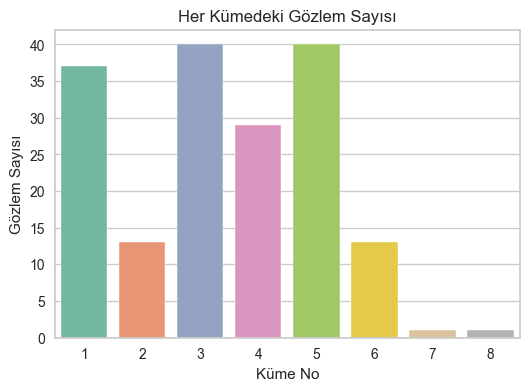

In [64]:
# Her kümede gözlem sayısı
cluster_counts = cluster_summary['TotalExpenditure_count']

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.title("Her Kümedeki Gözlem Sayısı")
plt.xlabel("Küme No")
plt.ylabel("Gözlem Sayısı")
plt.show()



In [49]:
# Eğer df_numeric sadece sayısalları içeriyorsa
df_numeric["Location"] = df["Location"]
clusters_countries = df_numeric.groupby("kmeans_cluster_no")["Location"].apply(list)

for cluster, countries in clusters_countries.items():
    print(f"\n📌 Küme {cluster} ({len(countries)} ülke):")
    print(", ".join(countries))


📌 Küme 1 (37 ülke):
Botswana, CentralAfricanRepublic, Lesotho, Eswatini, SouthAfrica, Zimbabwe, Argentina, Bahamas, Barbados, Canada, CostaRica, DominicanRepublic, Guatemala, Guyana, Honduras, Haiti, Jamaica, SaintLucia, Mexico, Nicaragua, Panama, Paraguay, ElSalvador, Suriname, Venezuela(BolivarianRepublicof), UnitedArabEmirates, Bahrain, Egypt, Iran(IslamicRepublicof), Kuwait, Libya, Qatar, Indonesia, Thailand, China, RepublicofKorea, Singapore

📌 Küme 2 (13 ülke):
Namibia, Colombia, TrinidadandTobago, Cyprus, Finland, France, UnitedKingdomofGreatBritainandNorthernIreland, Greece, Ireland, Israel, Malta, Portugal, NewZealand

📌 Küme 3 (40 ülke):
Angola, Burundi, Benin, BurkinaFaso, Coted'Ivoire, Cameroon, DemocraticRepublicoftheCongo, Congo, Comoros, CaboVerde, Eritrea, Ethiopia, Gabon, Ghana, Guinea, Gambia, Guinea-Bissau, EquatorialGuinea, Kenya, Liberia, Madagascar, Mali, Mozambique, Mauritania, Malawi, Niger, Nigeria, Rwanda, Senegal, SouthSudan, Chad, Togo, UnitedRepublicofTanz

📌Küme 1 (37 ülke)

Çoğunluk Afrika ve bazı Orta-Amerika ülkeleri.

Orta-düşük toplam harcama ve kişi başı harcama olasılığı yüksek.

Toplam harcama: 2577 ortalama

Kişi başı harcama: 51.95

Üretkenlik kaybı ve ağız sağlığı oranları: orta seviyede

Kanser vakaları: düşük-orta

Bu küme çoğunlukla orta gelirli ülkeler olabilir.

📌Küme 2 (13 ülke)

Avrupa’nın bazı refah düzeyi yüksek ülkeleri (İsviçre, Finland, İngiltere vb.)

Yüksek ağız sağlığı göstergeleri ve harcama ortalaması daha iyi olabilir.

Toplam harcama: 2172 ortalama

Kişi başı harcama: 91.9 (Küme 1’den yüksek)

Ağız sağlığı göstergeleri yüksek

Kanser vakaları orta seviyede

Avrupa’nın refah seviyesi orta-üst ülkeleri gibi görünüyor.

📌Küme 3 (40 ülke)

Afrika’nın düşük gelirli ülkeleri ağırlıklı.

Ağız sağlığı göstergelerinde sorunlu, harcamada düşük.

Toplam harcama çok düşük: 9.7

Kişi başı harcama 0.6 → ciddi düşük gelir

Ağız sağlığı göstergeleri kötü değil ama düşük harcama dikkat çekici

Kanser vakaları düşük → demografik ve raporlama etkisi olabilir.

📌Küme 4 (29 ülke)

Orta Doğu ve Güneydoğu Asya ülkeleri, gelişmekte olan ülkeler karışık.

Harcama ve sağlık göstergeleri karışık.

📌Küme 5 (40 ülke)

Güney Amerika ve Doğu Avrupa ağırlıklı.

Harcama ve sağlık göstergelerinde orta seviyeler.

(küme 4 ve küme 5 Orta harcama ve kişi başı harcama Ağız sağlığı ve kanser vakaları değişken

Muhtemelen gelişmekte olan ülkeler veya karışık gelir grubu)

📌Küme 6 (13 ülke)

Almanya, İsveç, Avusturya gibi zengin ülkeler + gelişmiş ülkeler.

Yüksek toplam ve kişi başı harcama, iyi ağız sağlığı göstergeleri.

Toplam ve kişi başı harcama yüksek (8154 ve 318 kişi başı)

Kanser vakaları orta-yüksek

Refah seviyesi yüksek ülkeler

📌Küme 7 (1 ülke)

ABD tek başına bir küme oluşturmuş.

Toplam ve kişi başı harcama çok yüksek

Kanser vakaları da çok yüksek

Büyük toplam harcama ama kişi başına değişkenlik gösterebilir.

Tek başına küme oluşması nüfus ve harcama etkisinden kaynaklanıyor.

📌Küme 8 (1 ülke)

Hindistan tek başına.

Çok büyük nüfus ve düşük kişi başı harcama nedeniyle ayrı küme.

Toplam harcama düşük, kişi başı harcama çok düşük

Kanser vakaları nüfus etkisiyle çok yüksek

Bu da nüfus büyüklüğü ve düşük kişi başı harcama etkisi.



🔹 Analiz Yorumları

Kümeleme, gelir ve sağlık göstergeleri ile coğrafi dağılımı birleştiriyor gibi.

Küme 6 Almanya dahil, yüksek harcama ve iyi sağlık göstergeleri ile zengin ülkeleri temsil ediyor.

Küme 1 ve 3, düşük gelir ve düşük sağlık göstergeleri olan ülkeleri temsil ediyor.

ABD ve Hindistan gibi nüfus etkisi çok yüksek ülkeler, tek başlarına ayrı küme oluşturmuş.

🔹 Genel Yorumlar

Harcamalar ve sağlık göstergeleri kümeleme için güçlü etken.

Nüfus etkisi (ABD, Hindistan) tekil kümeler oluşturuyor.

Avrupa ve yüksek gelirli ülkeler kendi küçük kümelerinde toplanmış (küme 6).

Düşük gelirli Afrika ve bazı Asya ülkeleri küme 3’te toplanmış.

In [50]:
countries = ['SaoTomeandPrincipe', 'Seychelles', 'AntiguaandBarbuda', 'Belize', 
             'Dominica', 'Grenada', 'SaintKittsandNevis', 'SaintVincentandtheGrenadines',
             'Andorra', 'Monaco', 'SanMarino', 'Micronesia(FederatedStatesof)', 
             'Kiribati', 'MarshallIslands', 'Nauru', 'Palau', 'Tonga', 'Tuvalu']

# Küme numaralarını al
cluster_info = df[df['Location'].isin(countries)][['Location', 'kmeans_cluster_no']]

print(cluster_info)


                          Location  kmeans_cluster_no
37              SaoTomeandPrincipe                  3
39                      Seychelles                  2
48               AntiguaandBarbuda                  1
50                          Belize                  1
59                        Dominica                  1
62                         Grenada                  1
68              SaintKittsandNevis                  1
80    SaintVincentandtheGrenadines                  1
104                        Andorra                  4
135                         Monaco                  4
146                      SanMarino                  4
171  Micronesia(FederatedStatesof)                  2
174                       Kiribati                  2
177                MarshallIslands                  2
180                          Nauru                  2
183                          Palau                  2
187                          Tonga                  2
188                         


Karşılaştırma:
                                   Germany  Cluster_Avg
TotalExpenditure                  30877.3       8154.6
PerCapitaExpenditure                372.2        318.5
EdentulismRate                       11.7         12.1
PeriodontalRate                      27.4         21.2
UntreatedCariesRate                  31.7         31.7
UntreatedDeciduousCaries11_9Rate     29.1         31.9
ProductivityLossRate              19395.9       5956.6
both_cancer                        7333.0       2362.9
female_cancer                      2855.0        907.6
male_cancer                        4478.0       1455.3


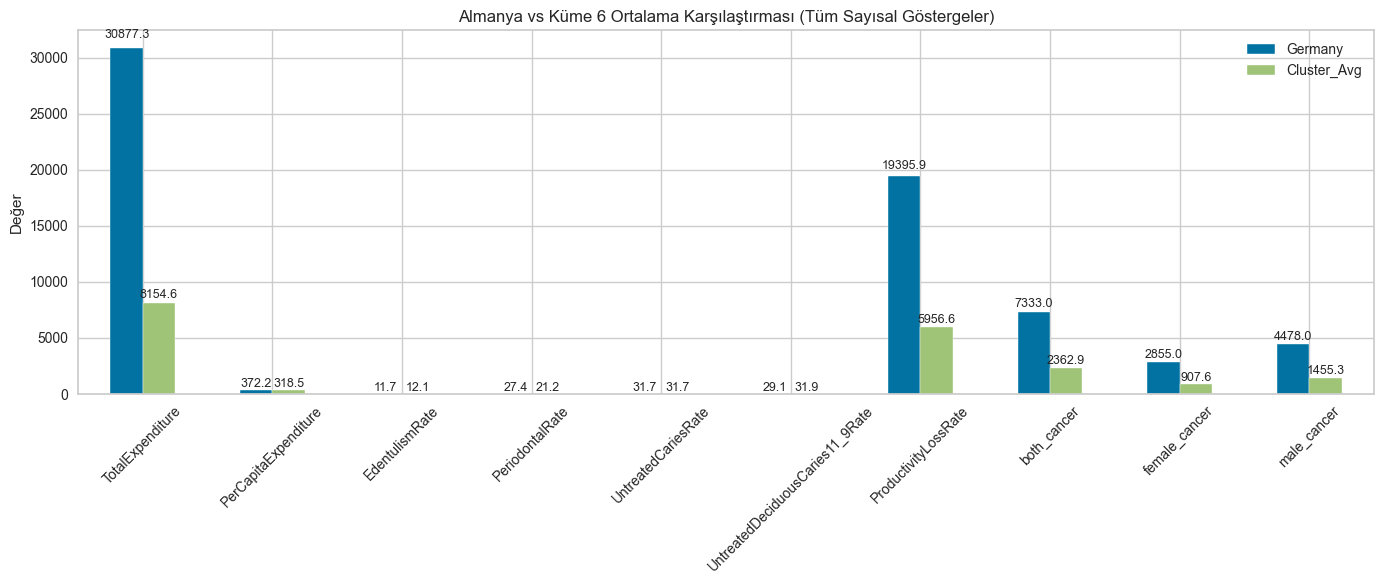

In [51]:

# Tüm sayısal sütunlar
numerical_cols = df_numeric.select_dtypes(include="number").columns.tolist()
numerical_cols.remove("kmeans_cluster_no")  # Küme etiketi karşılaştırmaya dahil olmasın

# Almanya'nın değerleri
germany_values = df_numeric[df_numeric["Location"] == "Germany"][numerical_cols]

# Almanya'nın küme numarası
germany_cluster = df_numeric[df_numeric["Location"] == "Germany"]["kmeans_cluster_no"].values[0]

# Küme ortalamaları
cluster_mean = df_numeric[df_numeric["kmeans_cluster_no"] == germany_cluster][numerical_cols].mean()

# Karşılaştırma tablosu ve 1 ondalık basamak
comparison = pd.DataFrame({
    "Germany": germany_values.values.flatten(),
    "Cluster_Avg": cluster_mean.values
}, index=numerical_cols).round(1)

print("\nKarşılaştırma:\n", comparison)

# Görselleştirme - Barplot
ax = comparison.plot(kind="bar", figsize=(14,6))

# Barların üstüne y değerlerini yaz
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width()/2., 
            y=height + 0.02*height,  # bar üstünde boşluk
            s=f'{height:.1f}',       # 1 ondalık basamak
            ha='center', va='bottom', fontsize=9)

plt.title(f"Almanya vs Küme {germany_cluster} Ortalama Karşılaştırması (Tüm Sayısal Göstergeler)")
plt.ylabel("Değer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

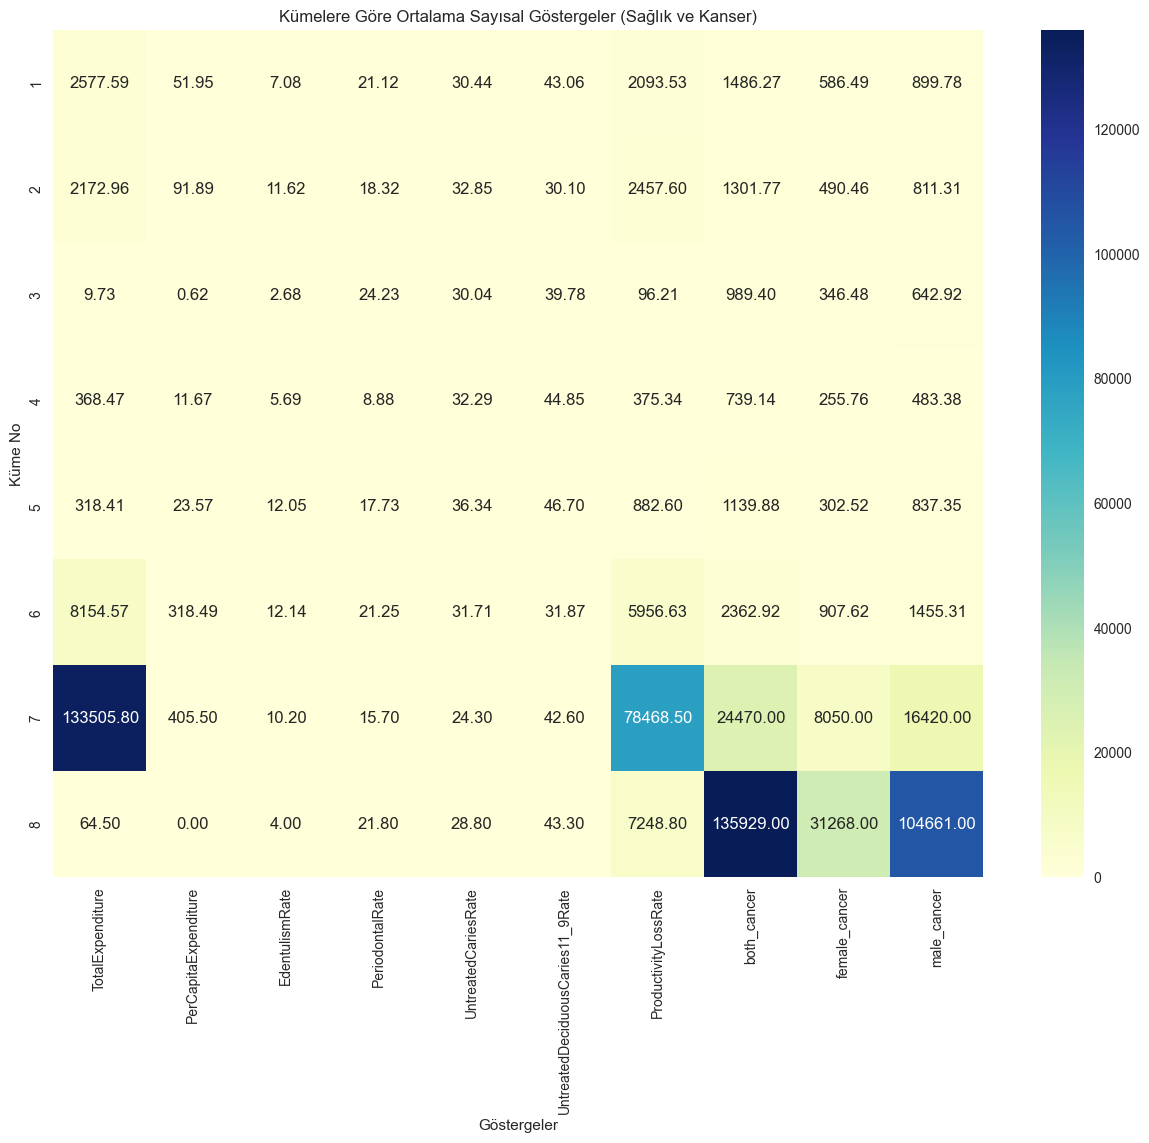

In [52]:
# Sadece sayısal sütunlar
numeric_cols = df_numeric.select_dtypes(include='number').columns.drop('kmeans_cluster_no')

# Küme bazında ortalamalar
cluster_means = df_numeric.groupby("kmeans_cluster_no")[numeric_cols].mean()

# Heatmap görselleştirme
plt.figure(figsize=(15,11))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Kümelere Göre Ortalama Sayısal Göstergeler (Sağlık ve Kanser)")
plt.xlabel("Göstergeler")
plt.ylabel("Küme No")
plt.show()

Cophenetic Correlation: 0.602
n_clusters=2, Silhouette Score=0.806
n_clusters=3, Silhouette Score=0.773
n_clusters=4, Silhouette Score=0.384
n_clusters=5, Silhouette Score=0.270
n_clusters=6, Silhouette Score=0.286
n_clusters=7, Silhouette Score=0.280
n_clusters=8, Silhouette Score=0.277
n_clusters=9, Silhouette Score=0.215
✅ Optimal küme sayısı: 2, Silhouette Score: 0.806


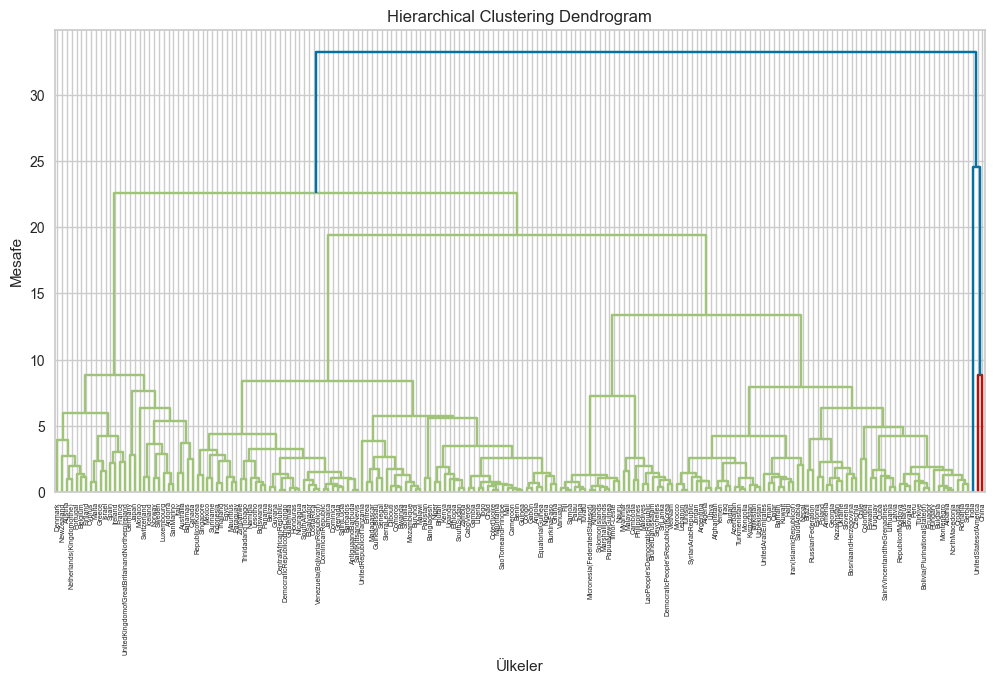

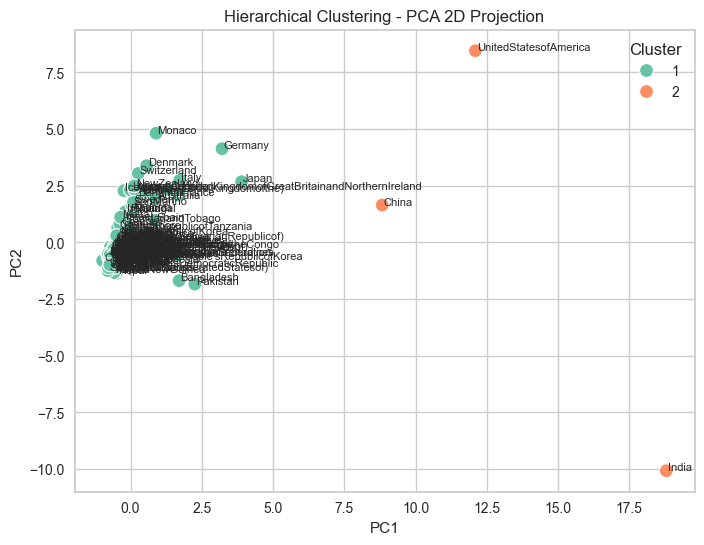


📊 Küme Özet Tablosu (Ortalamalar):
          TotalExpenditure  PerCapitaExpenditure  EdentulismRate  \
hcluster                                                           
1              1015.733333             53.412698        7.660847   
2             65039.633333            149.833333        6.633333   

          PeriodontalRate  UntreatedCariesRate  \
hcluster                                         
1               18.441270            32.357143   
2               18.333333            25.900000   

          UntreatedDeciduousCaries11_9Rate  ProductivityLossRate  \
hcluster                                                           
1                                41.692063           1011.938624   
2                                44.366667          43810.133333   

          both_cancer_fill  female_cancer   male_cancer  
hcluster                                                 
1               964.635498     360.707602    686.789474  
2             63505.333333   16963.000000  

In [65]:

#Hierarchical Clustering (Hiyerarşik Kümeleme)

#Amaç: Veri setindeki ülkeleri veya gözlemleri benzerliklerine göre gruplamak.

#Hiyerarşik yöntem, gözlemler arasındaki mesafeyi kullanarak ağaç yapısı (dendrogram) oluşturur.

#Bu sayede hangi gözlemlerin birbirine yakın olduğu ve hangi gözlemlerden daha farklı olduğu anlaşılır.

#Görselleştirme: PCA ile 2D Projeksiyon

#Amaç: Yüksek boyutlu veriyi 2 boyuta indirerek kümeleri görselleştirmek.

#Renkler = kümeler → her küme farklı renkle gösterilir, böylece hangi gözlemlerin aynı kümeye ait olduğu kolayca görülür.



def hierarchical_clustering_pipeline(df, features, cluster_range=range(2,10)):
    # Eksik değerleri doldurma: both_cancer_fill
    if 'both_cancer_fill' not in df.columns:
        if 'kmeans_cluster_no' in df.columns:
            df["both_cancer_fill"] = df.groupby(
                ["ExpenditureGroup", "kmeans_cluster_no"]
            )["both_cancer"].transform(lambda x: x.fillna(x.mean()))
        else:
            df["both_cancer_fill"] = df.groupby(
                ["ExpenditureGroup"]
            )["both_cancer"].transform(lambda x: x.fillna(x.mean()))
    
    # 1️⃣ Veri ölçeklendirme
    X = df[features].fillna(df[features].mean())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2️⃣ Hiyerarşik kümeleme
    Z = linkage(X_scaled, method='ward')
    
    # 3️⃣ Cophenetic correlation
    c, _ = cophenet(Z, pdist(X_scaled))
    print(f"Cophenetic Correlation: {c:.3f}")

    # 4️⃣ Optimal küme sayısı (Silhouette Score)
    best_score = -1
    best_k = 2
    for k in cluster_range:
        clusters = fcluster(Z, t=k, criterion='maxclust')
        score = silhouette_score(X_scaled, clusters)
        print(f"n_clusters={k}, Silhouette Score={score:.3f}")
        if score > best_score:
            best_score = score
            best_k = k
    print(f"✅ Optimal küme sayısı: {best_k}, Silhouette Score: {best_score:.3f}")
    
    # 5️⃣ Küme ataması
    df['hcluster'] = fcluster(Z, t=best_k, criterion='maxclust')

    # 6️⃣ Dendrogram
    plt.figure(figsize=(12,6))
    dendrogram(Z, labels=df["Location"].values, color_threshold=None)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Ülkeler")
    plt.ylabel("Mesafe")
    plt.xticks(rotation=90)
    plt.show()

    # 7️⃣ PCA ile 2D projeksiyon
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1], 
        hue=df['hcluster'], 
        palette='Set2', s=100
    )

    for i, txt in enumerate(df["Location"]):
        plt.text(X_pca[i,0]+0.05, X_pca[i,1], txt, fontsize=8)

    plt.title("Hierarchical Clustering - PCA 2D Projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.show()
    
    # 8️⃣ Küme özet tablosu
    cluster_summary = df.groupby("hcluster")[features].mean()
    print("\n📊 Küme Özet Tablosu (Ortalamalar):")
    print(cluster_summary)

    return df, best_k, best_score

# Jupyter için
%matplotlib inline
import matplotlib.pyplot as plt

# Özellik listesi
features = [
    'TotalExpenditure', 'PerCapitaExpenditure',
    'EdentulismRate', 'PeriodontalRate', 'UntreatedCariesRate',
    'UntreatedDeciduousCaries11_9Rate', 'ProductivityLossRate',
    'both_cancer_fill', 'female_cancer', 'male_cancer'
]

# Fonksiyonu çağır
df, optimal_k, silhouette = hierarchical_clustering_pipeline(df, features)


##### Regression Model

In [54]:
df.isnull().sum()

Location                             0
TotalExpenditure                     0
PerCapitaExpenditure                 0
EdentulismRate                       0
PeriodontalRate                      0
UntreatedCariesRate                  0
UntreatedDeciduousCaries11_9Rate     0
ProductivityLossRate                 0
both_cancer                         18
female_cancer                       18
male_cancer                         18
ExpenditureGroup                     0
kmeans_cluster_no                    0
dtype: int64

In [55]:
df.columns

Index(['Location', 'TotalExpenditure', 'PerCapitaExpenditure',
       'EdentulismRate', 'PeriodontalRate', 'UntreatedCariesRate',
       'UntreatedDeciduousCaries11_9Rate', 'ProductivityLossRate',
       'both_cancer', 'female_cancer', 'male_cancer', 'ExpenditureGroup',
       'kmeans_cluster_no'],
      dtype='object')

In [56]:

#REGRESYON MODELLERİ

# Boş liste: sonuçlar burada tutulacak
results = []

# Hedef ve özellikler
df["both_cancer_fill"] = df.groupby(["ExpenditureGroup", "kmeans_cluster_no"])["both_cancer"].transform(
    lambda x: x.fillna(x.mean())
)

target = 'ProductivityLossRate'  
features = ['TotalExpenditure', 'PerCapitaExpenditure', 'EdentulismRate', 
            'PeriodontalRate', 'UntreatedCariesRate', 'both_cancer_fill']

X = df[features]
y = df[target]

# Eğitim / test seti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeller
regressors = [
    ("LinearRegression", LinearRegression()),
    ("KNN", KNeighborsRegressor()),
    ("CART", DecisionTreeRegressor()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42, eval_metric='rmse'))
]

# Modelleri eğit ve metrikleri hesapla
for name, model in regressors:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        "Model": name,
        "R2": round(r2_score(y_test, y_pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 4),
        "MAE": round(mean_absolute_error(y_test, y_pred), 4)
    })

# Sonuçları DataFrame olarak göster
results_df = pd.DataFrame(results)
print(results_df)




C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\1495615574.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["both_cancer_fill"] = df.groupby(["ExpenditureGroup", "kmeans_cluster_no"])["both_cancer"].transform(


              Model      R2       RMSE       MAE
0  LinearRegression  0.8788  1156.2920  555.6518
1               KNN  0.7560  1640.7891  616.1831
2              CART  0.6815  1874.6813  747.2615
3      RandomForest  0.8791  1154.9169  439.8851
4  GradientBoosting  0.9010  1045.1138  434.9410
5           XGBoost  0.8945  1078.8830  401.1981


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\2449112737.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="Set2")
C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\2449112737.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="Set2")
C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\2449112737.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, palette="Set2")


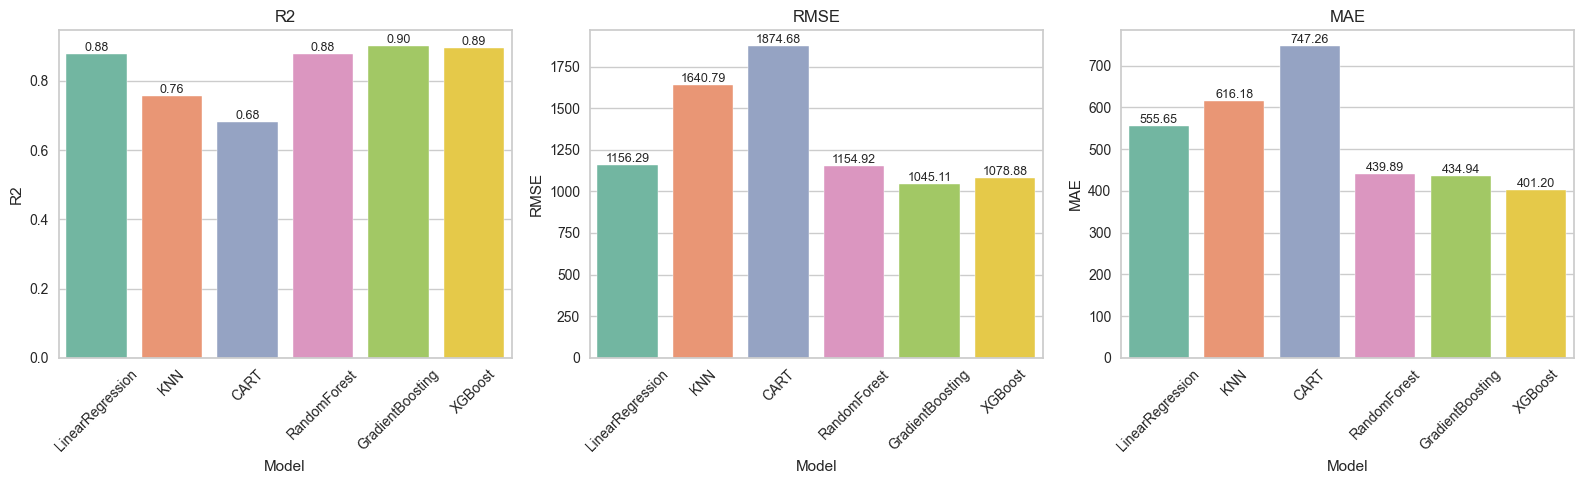

In [57]:

# Önceki kodla sonuçlar df içinde hazır
# results_df = pd.DataFrame(results)

# R², RMSE ve MAE için ayrı barplotlar
metrics = ["R2", "RMSE", "MAE"]

plt.figure(figsize=(16, 5))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x="Model", y=metric, data=results_df, palette="Set2")
    
    # Barların üstüne değerleri yaz
    for p in plt.gca().patches:
        plt.gca().annotate(f"{p.get_height():.2f}", 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom', fontsize=9)
    
    plt.title(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\nesri\AppData\Local\Temp\ipykernel_23360\486763992.py:28: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\nesri\repos\bitirme projesi\GlobalDentalStats\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


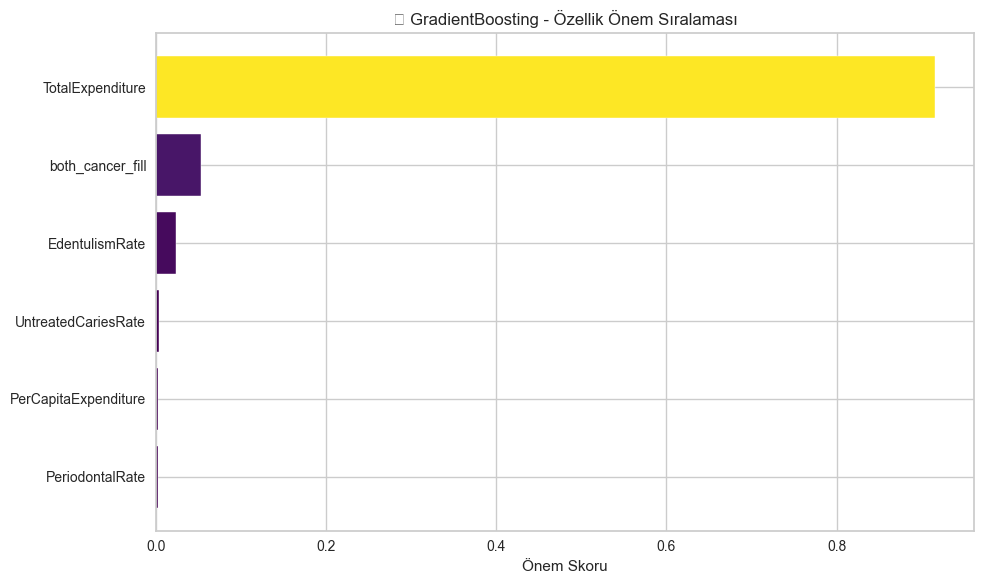

Feature Importances: [0.91562051 0.00242307 0.02391441 0.0021368  0.00309657 0.05280864]


In [ ]:


# 🔹 Modeli oluştur ve eğit
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)  # X_train ve y_train daha önce tanımlı olmalı

# 🔹 Feature importance
importances = gb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# 🔹 Görselleştirme
plt.figure(figsize=(10, 6))
colors = cm.viridis(importance_df['Importance'] / importance_df['Importance'].max())
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel("Önem Skoru")
plt.title("📌 GradientBoosting - Özellik Önem Sıralaması")
plt.tight_layout()
plt.show()

# 🔹 İsteğe bağlı: best_models sözlüğüne ekle
best_models = {}
best_models['GradientBoosting'] = gb_model

print("Feature Importances:", importances)



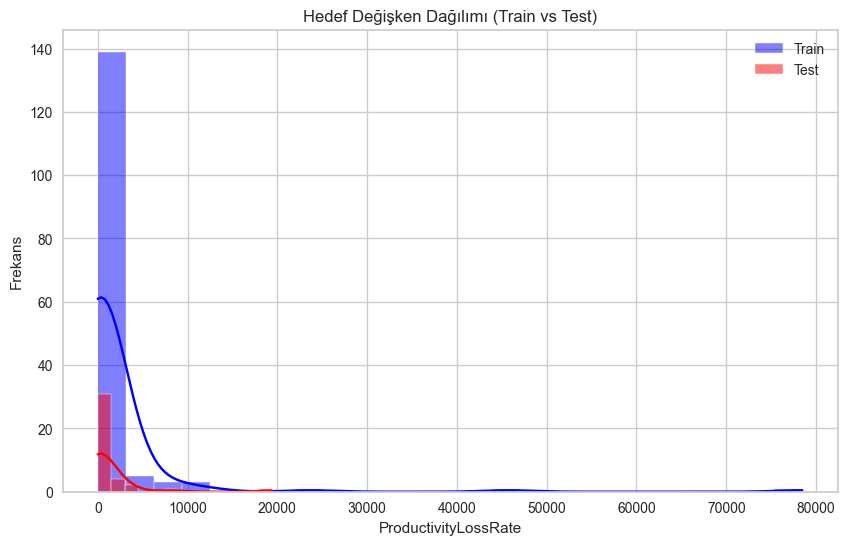

In [ ]:
plt.figure(figsize=(10, 6))

# Histogram + KDE
sns.histplot(y_train, color="blue", label="Train", kde=True, alpha=0.5)
sns.histplot(y_test, color="red", label="Test", kde=True, alpha=0.5)


plt.legend()
plt.title("Hedef Değişken Dağılımı (Train vs Test)")
plt.xlabel("ProductivityLossRate")
plt.ylabel("Frekans")
plt.show()


SINIFLANDIRMA MODELLERİ

In [ ]:


#Ülkelerin sağlık ve harcama göstergelerine bakarak, onları harcama gruplarına (Low / Medium / High) sınıflandırmak.

df["both_cancer_fill"] = df.groupby(
    ["ExpenditureGroup", "kmeans_cluster_no"]
)["both_cancer"].transform(lambda x: x.fillna(x.mean()))


# Özellikler ve hedef
features = ['TotalExpenditure', 'PerCapitaExpenditure',
            'EdentulismRate', 'PeriodontalRate', 'UntreatedCariesRate',
            'UntreatedDeciduousCaries11_9Rate', 'ProductivityLossRate',
            'both_cancer_fill', 'female_cancer', 'male_cancer']
target = 'ExpenditureGroup'

X = df[features].fillna(df[features].mean())
y = LabelEncoder().fit_transform(df[target])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model örneği
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[18  0  1]
 [ 0 19  0]
 [ 0  1 19]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.95      1.00      0.97        19
           2       0.95      0.95      0.95        20

    accuracy                           0.97        58
   macro avg       0.97      0.97      0.97        58
weighted avg       0.97      0.97      0.97        58



Satırlar gerçek sınıfları, sütunlar tahmin edilen sınıfları gösterir.


1. satır (gerçek sınıf 0) → 19 örneğin 18’i doğru tahmin edilmiş, 1’i yanlışlıkla sınıf 2’ye gitmiş.

2. satır (gerçek sınıf 1) → 19 örneğin hepsi doğru tahmin edilmiş.

3. satır (gerçek sınıf 2) → 20 örneğin 19’u doğru, 1’i yanlışlıkla sınıf 1’e gitmiş.

📌 Demek ki model sadece 2 örneği yanlış sınıflandırmış.

📈 Classification Report
Precision (Kesinlik)

0 için: 1.00 → Model "sınıf 0" dediğinde %100 doğru.

1 için: 0.95 → Model "sınıf 1" dediğinde %95 doğru.

2 için: 0.95 → Model "sınıf 2" dediğinde %95 doğru.

Ortalama: ~0.97 → Oldukça yüksek.

Recall (Duyarlılık)

0 için: 0.95 → Gerçekten sınıf 0 olanların %95’i doğru bulunmuş.

1 için: 1.00 → Tüm sınıf 1’ler doğru yakalanmış.

2 için: 0.95 → Sınıf 2’nin %95’i doğru bulunmuş.

Ortalama: ~0.97

F1-Score (Precision & Recall’un dengesi)

0: 0.97

1: 0.97

2: 0.95

Genel: 0.97

Accuracy (Genel Doğruluk)

%97 → 58 örneğin sadece 2 tanesi yanlış sınıflandırılmış.

🎯 Sonuç

Model çok yüksek doğrulukla (97%) sınıflandırma yapıyor.

Hem precision hem recall değerleri 0.95+ → sınıflar arasında dengesizlik yok, yani model her sınıfta tutarlı çalışıyor.

Yanlışlar çok az → sadece sınıf 0 ↔ 2 ve sınıf 2 ↔ 1 arasında küçük karışıklık var.

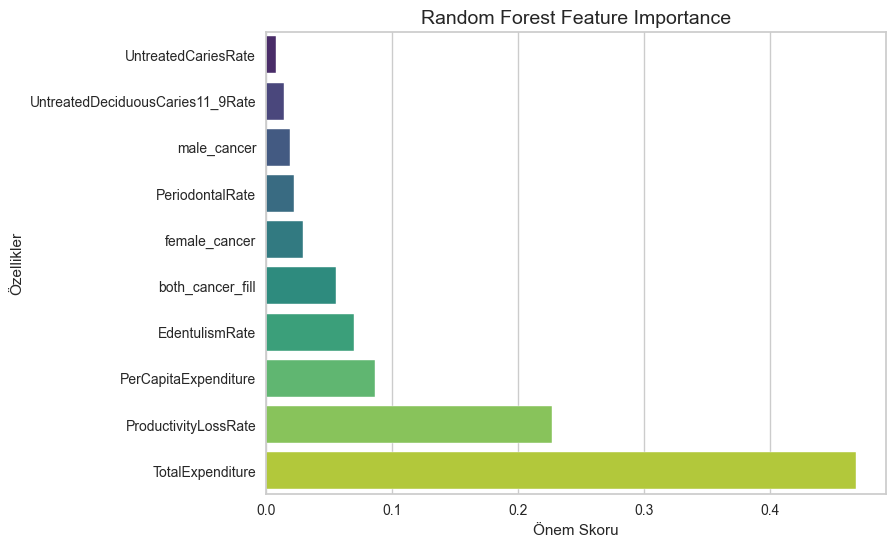

In [ ]:

# Özellik önemlerini çıkar
feat_importances = pd.Series(rf.feature_importances_, index=features)

# Küçükten büyüğe sırala
feat_importances = feat_importances.sort_values(ascending=True)

# Görselleştir
plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances, y=feat_importances.index, palette="viridis")
plt.title("Random Forest Feature Importance", fontsize=14)
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.show()


In [ ]:
# Amaç: Ülkeleri çürük prevalansına göre (UntreatedCariesRate) 3 kategoriye ayırmak ve sınıflandırmak.

# 1. Hedef değişken oluşturma (örnek: çürük oranına göre 3 kategori)
df["CariesGroup_quantile"] = pd.qcut(
    df["UntreatedCariesRate"], 
    q=3, 
    labels=["Low", "Medium", "High"]
)


# 2. Özellikler ve hedef
features = [
    'TotalExpenditure', 'PerCapitaExpenditure',
    'EdentulismRate', 'PeriodontalRate',
    'UntreatedDeciduousCaries11_9Rate', 'ProductivityLossRate',
    'both_cancer_fill', 'female_cancer', 'male_cancer'
]
target = "CariesGroup"

X = df[features].fillna(df[features].mean())
y = LabelEncoder().fit_transform(df[target])

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5a. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
print("=== Random Forest ===")
print(confusion_matrix(y_test, rf.predict(X_test_scaled)))
print(classification_report(y_test, rf.predict(X_test_scaled)))

# 5b. XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train_scaled, y_train)
print("=== XGBoost ===")
print(confusion_matrix(y_test, xgb.predict(X_test_scaled)))
print(classification_report(y_test, xgb.predict(X_test_scaled)))


=== Random Forest ===
[[14  1  4]
 [ 5  9  6]
 [ 4  7  8]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        19
           1       0.53      0.45      0.49        20
           2       0.44      0.42      0.43        19

    accuracy                           0.53        58
   macro avg       0.53      0.54      0.53        58
weighted avg       0.53      0.53      0.53        58

=== XGBoost ===
[[13  2  4]
 [ 5  8  7]
 [ 4  6  9]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        19
           1       0.50      0.40      0.44        20
           2       0.45      0.47      0.46        19

    accuracy                           0.52        58
   macro avg       0.51      0.52      0.51        58
weighted avg       0.51      0.52      0.51        58



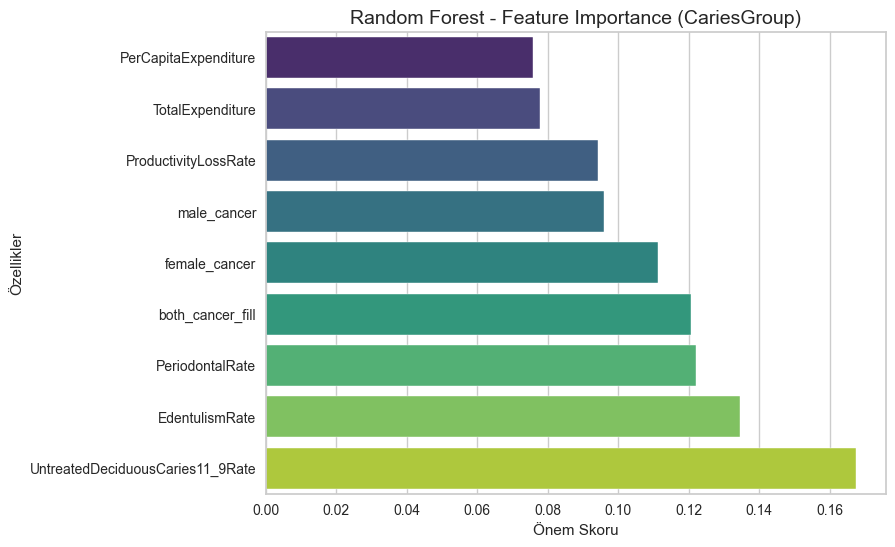

In [ ]:


# Random Forest feature importance
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values()

plt.figure(figsize=(8,6))
sns.barplot(x=rf_importances, y=rf_importances.index, palette="viridis")
plt.title("Random Forest - Feature Importance (CariesGroup)", fontsize=14)
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.show()


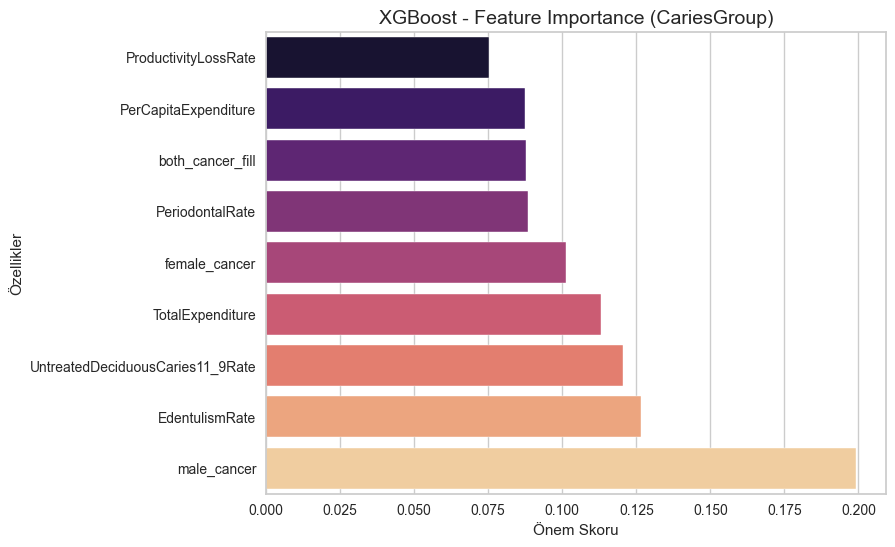

In [ ]:
# XGBoost feature importance
xgb_importances = pd.Series(xgb.feature_importances_, index=features).sort_values()

plt.figure(figsize=(8,6))
sns.barplot(x=xgb_importances, y=xgb_importances.index, palette="magma")
plt.title("XGBoost - Feature Importance (CariesGroup)", fontsize=14)
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.show()


🔍 FEATURE IMPORTANCE ANALİZ RAPORU

🎯 HEDEF DEĞİŞKEN: Çocuklarda Çürük


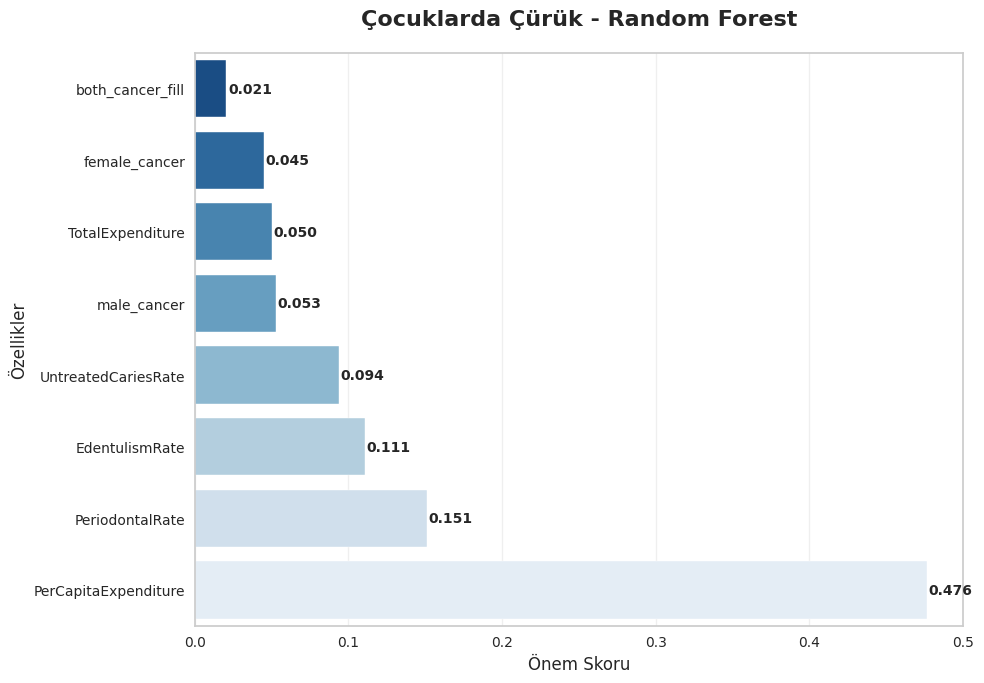


📊 Çocuklarda Çürük - Random Forest - En Önemli 3 Özellik:
1. PerCapitaExpenditure: 0.4763
2. PeriodontalRate: 0.1513
3. EdentulismRate: 0.1107
--------------------------------------------------


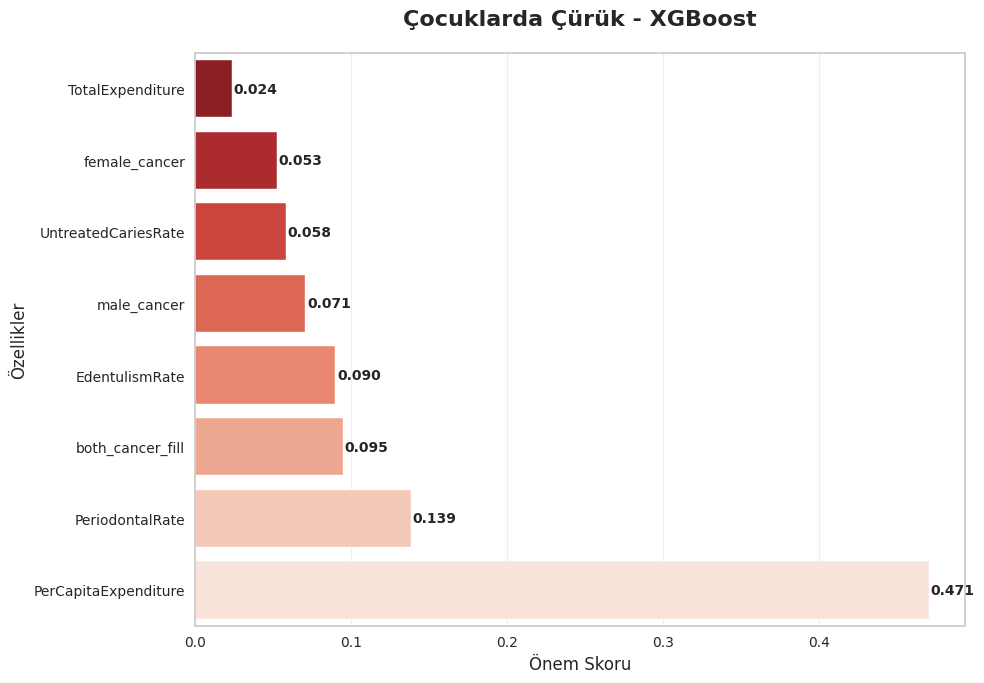


📊 Çocuklarda Çürük - XGBoost - En Önemli 3 Özellik:
1. PerCapitaExpenditure: 0.4706
2. PeriodontalRate: 0.1387
3. both_cancer_fill: 0.0949
--------------------------------------------------

📈 Çocuklarda Çürük - Model Karşılaştırması:
                      Random Forest  XGBoost
PerCapitaExpenditure         0.4763   0.4706
PeriodontalRate              0.1513   0.1387
EdentulismRate               0.1107   0.0902
UntreatedCariesRate          0.0938   0.0584
male_cancer                  0.0527   0.0709
TotalExpenditure             0.0499   0.0236
female_cancer                0.0447   0.0527
both_cancer_fill             0.0206   0.0949

🎯 HEDEF DEĞİŞKEN: Productivity Loss


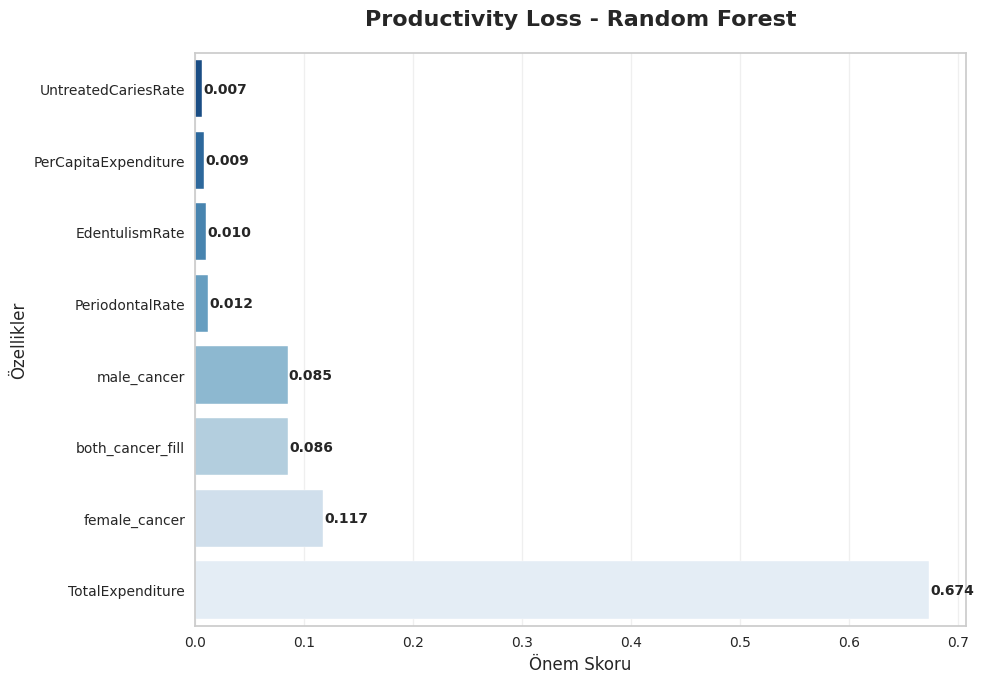


📊 Productivity Loss - Random Forest - En Önemli 3 Özellik:
1. TotalExpenditure: 0.6736
2. female_cancer: 0.1175
3. both_cancer_fill: 0.0857
--------------------------------------------------


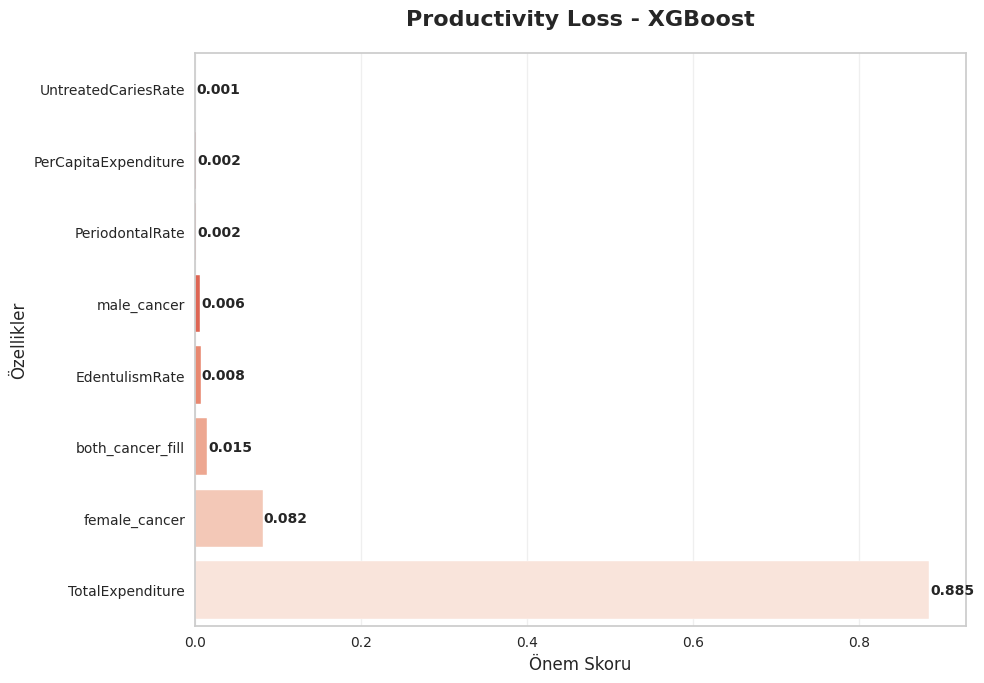


📊 Productivity Loss - XGBoost - En Önemli 3 Özellik:
1. TotalExpenditure: 0.8847
2. female_cancer: 0.0822
3. both_cancer_fill: 0.0149
--------------------------------------------------

📈 Productivity Loss - Model Karşılaştırması:
                      Random Forest  XGBoost
TotalExpenditure             0.6736   0.8847
female_cancer                0.1175   0.0822
both_cancer_fill             0.0857   0.0149
male_cancer                  0.0853   0.0064
PeriodontalRate              0.0122   0.0019
EdentulismRate               0.0103   0.0075
PerCapitaExpenditure         0.0088   0.0017
UntreatedCariesRate          0.0066   0.0007

🎯 HEDEF DEĞİŞKEN: Kanser Vakaları


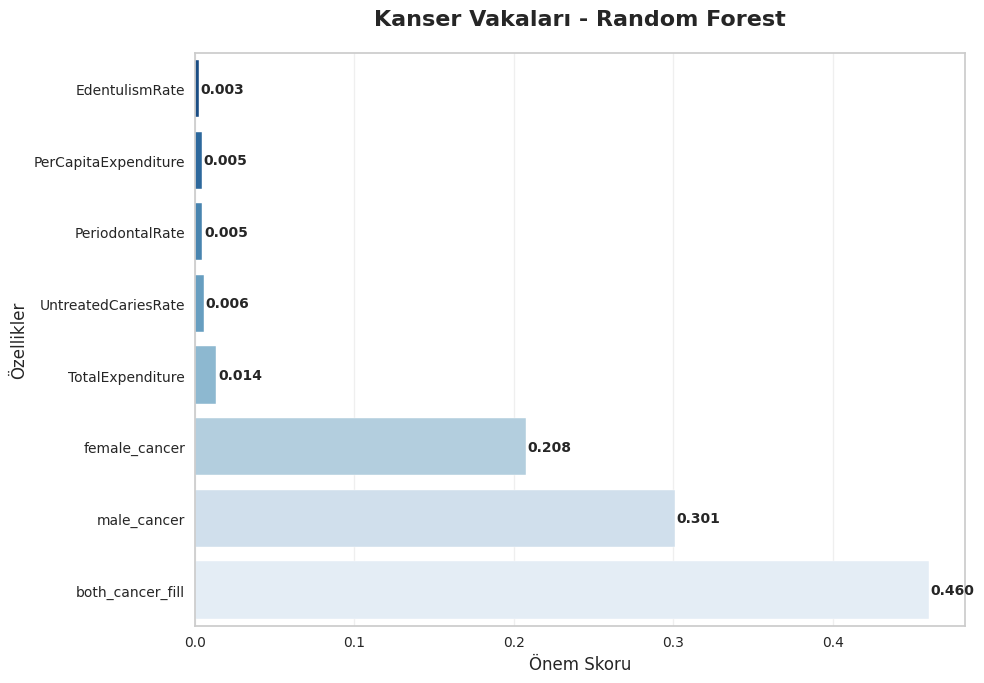


📊 Kanser Vakaları - Random Forest - En Önemli 3 Özellik:
1. both_cancer_fill: 0.4600
2. male_cancer: 0.3011
3. female_cancer: 0.2076
--------------------------------------------------


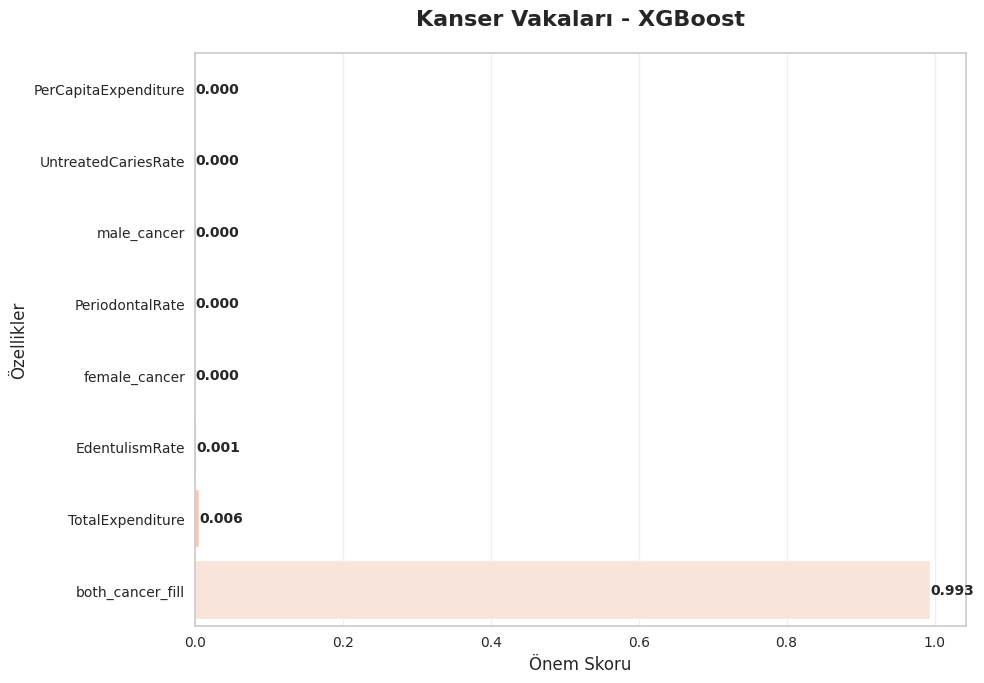


📊 Kanser Vakaları - XGBoost - En Önemli 3 Özellik:
1. both_cancer_fill: 0.9934
2. TotalExpenditure: 0.0055
3. EdentulismRate: 0.0010
--------------------------------------------------

📈 Kanser Vakaları - Model Karşılaştırması:
                      Random Forest  XGBoost
both_cancer_fill             0.4600   0.9934
male_cancer                  0.3011   0.0000
female_cancer                0.2076   0.0000
TotalExpenditure             0.0135   0.0055
UntreatedCariesRate          0.0057   0.0000
PeriodontalRate              0.0047   0.0000
PerCapitaExpenditure         0.0046   0.0000
EdentulismRate               0.0028   0.0010

📋 ÖZET RAPOR - TÜM HEDEF DEĞİŞKENLER

🏆 Tüm Modeller İçin Feature Importance Özeti:
                      Çocuk Çürük (RF)  Çocuk Çürük (XGB)  Prod Loss (RF)  \
PerCapitaExpenditure            0.4763             0.4706          0.0088   
PeriodontalRate                 0.1513             0.1387          0.0122   
EdentulismRate                  0.1107            

In [ ]:
# Feature Importance Analizi - Çoklu Model ve Hedef Değişken Karşılaştırması


# Türkçe karakter desteği için
plt.rcParams['font.family'] = 'DejaVu Sans'

# 1. Ortak özellikler (bağımsız değişkenler)
features = [
    'TotalExpenditure', 'PerCapitaExpenditure',
    'EdentulismRate', 'PeriodontalRate', 
    'UntreatedCariesRate',
    'both_cancer_fill', 'female_cancer', 'male_cancer'
]

# Fonksiyon: Gelişmiş Feature Importance Görselleştirme
def plot_feature_importance(model, X, y, feature_names, title, color_palette="viridis"):
    """
    Feature importance'ı hesaplar ve görselleştirir
    """
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, 
                           index=feature_names).sort_values(ascending=True)
    
    plt.figure(figsize=(10, 7))
    bars = sns.barplot(x=importances.values, y=importances.index, 
                      palette=color_palette)
    
    # Değerleri çubukların üzerine yazma
    for i, (idx, val) in enumerate(importances.items()):
        plt.text(val + 0.001, i, f'{val:.3f}', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Önem Skoru", fontsize=12)
    plt.ylabel("Özellikler", fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top 3 önemli özelliği yazdır
    print(f"\n📊 {title} - En Önemli 3 Özellik:")
    for i, (feature, importance) in enumerate(importances.tail(3).iloc[::-1].items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")
    print("-" * 50)
    
    return importances

# Fonksiyon: Model Karşılaştırması
def compare_models_for_target(X, y, target_name, features):
    """
    Aynı hedef değişken için RF ve XGBoost karşılaştırması
    """
    print(f"\n{'='*60}")
    print(f"🎯 HEDEF DEĞİŞKEN: {target_name}")
    print(f"{'='*60}")
    
    # Random Forest
    rf_importance = plot_feature_importance(
        RandomForestRegressor(n_estimators=200, random_state=42),
        X, y, features, 
        f"{target_name} - Random Forest",
        "Blues_r"
    )
    
    # XGBoost  
    xgb_importance = plot_feature_importance(
        XGBRegressor(n_estimators=200, learning_rate=0.1, 
                    max_depth=5, random_state=42),
        X, y, features,
        f"{target_name} - XGBoost", 
        "Reds_r"
    )
    
    # Model karşılaştırma tablosu
    comparison_df = pd.DataFrame({
        'Random Forest': rf_importance,
        'XGBoost': xgb_importance
    }).round(4)
    
    print(f"\n📈 {target_name} - Model Karşılaştırması:")
    print(comparison_df.sort_values('Random Forest', ascending=False))
    
    return rf_importance, xgb_importance

# Ana veri setini hazırla
X = df[features]

# HEDEF DEĞİŞKEN ANALİZLERİ
print("🔍 FEATURE IMPORTANCE ANALİZ RAPORU")
print("="*80)

# 1. Çocuklarda Çürük Analizi
y_child_caries = df["UntreatedDeciduousCaries11_9Rate"]
rf_child, xgb_child = compare_models_for_target(
    X, y_child_caries, "Çocuklarda Çürük", features
)

# 2. Productivity Loss Analizi  
y_prod_loss = df["ProductivityLossRate"]
rf_prod, xgb_prod = compare_models_for_target(
    X, y_prod_loss, "Productivity Loss", features
)

# 3. Kanser Vakaları Analizi
y_cancer = df["both_cancer_fill"] 
rf_cancer, xgb_cancer = compare_models_for_target(
    X, y_cancer, "Kanser Vakaları", features
)

# ÖZET RAPOR
print(f"\n{'='*80}")
print("📋 ÖZET RAPOR - TÜM HEDEF DEĞİŞKENLER")
print(f"{'='*80}")

# En önemli özellikler özet tablosu
summary_df = pd.DataFrame({
    'Çocuk Çürük (RF)': rf_child,
    'Çocuk Çürük (XGB)': xgb_child,
    'Prod Loss (RF)': rf_prod, 
    'Prod Loss (XGB)': xgb_prod,
    'Kanser (RF)': rf_cancer,
    'Kanser (XGB)': xgb_cancer
}).round(4)

print("\n🏆 Tüm Modeller İçin Feature Importance Özeti:")
print(summary_df.sort_values('Çocuk Çürük (RF)', ascending=False))

# En tutarlı özellikler
print("\n⭐ En Tutarlı (Genellikle Önemli) Özellikler:")
mean_importance = summary_df.mean(axis=1).sort_values(ascending=False)
for i, (feature, avg_imp) in enumerate(mean_importance.head(5).items(), 1):
    print(f"{i}. {feature}: {avg_imp:.4f} (ortalama)")
